<a href="https://colab.research.google.com/github/margaritavit/min_order_picking_path/blob/main/workshop__order_picking_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time

In [2]:
start=time.time()

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
import collections

# PART 1: Generate and visualize network of parts

## 1.1 Nodes of parts network

### 1.1.1 Read 'nodes.csv': create dataframe of parts and their properties (frequency, category)
<b>part_abs_freq</b>: the number of pickslips a part appears  
<b>type</b>: part category

In [4]:
df_nodes=pd.read_csv('nodes.csv')

In [5]:
print('Total number of parts in the network:', len(df_nodes))
print('')
df_nodes.sort_values(by=['part_abs_freq'],ascending=False)

Total number of parts in the network: 19607



part_id  part_abs_freq                   type
13977  part_8589934734          11057             Consumable
19590  part_8589934678           6631             Consumable
14000  part_8589935130           6277             Consumable
18314  part_8589934694           5337             Consumable
13635  part_8589934747           4954  Non-aircraft material
...                ...            ...                    ...
3715   part_8590032381              1                   Part
3718   part_8589955331              1             Consumable
12512  part_8590253030              1                   Part
12510  part_8590071468              1                   Part
19606  part_8590262010              1             Consumable

[19607 rows x 3 columns]

In [6]:
# parts that have been requested only once (appear in only one picking slip)

df1=df_nodes[df_nodes['part_abs_freq']==1]
print('There are', len(df1), 'parts that have been requested in only one pickslip.' )
print('')
df1

There are 6514 parts that have been requested in only one pickslip.



part_id  part_abs_freq        type
6      part_8589949321              1  Consumable
9      part_8590185070              1  Consumable
12     part_8590090658              1  Consumable
15     part_8590074330              1  Consumable
16     part_8590087917              1  Consumable
...                ...            ...         ...
19592  part_8590064598              1  Consumable
19594  part_8589969666              1        Part
19597  part_8590040873              1        Part
19602  part_8590142675              1        Part
19606  part_8590262010              1  Consumable

[6514 rows x 3 columns]

### 1.1.2 Candidate nodes for the parts network
Drop the ones with part_abs_freq $\leq$ node_thres.   
$node$_$thres=15$ : Drop the nodes that appear in less than 16 pickslips

In [7]:
# parts that have been requested in less than or equal to node_thres pickslips
node_thres=15

df1=df_nodes[df_nodes['part_abs_freq']<=node_thres]
print('There are', len(df1), 'parts that have been requested in less than', node_thres+1, 'pickslips.' )
print('')

df_nodes_new=df_nodes[df_nodes['part_abs_freq']>node_thres]

df_nodes_new.sort_values(by=['part_abs_freq'],ascending=False)

There are 16794 parts that have been requested in less than 16 pickslips.



part_id  part_abs_freq                   type
13977  part_8589934734          11057             Consumable
19590  part_8589934678           6631             Consumable
14000  part_8589935130           6277             Consumable
18314  part_8589934694           5337             Consumable
13635  part_8589934747           4954  Non-aircraft material
...                ...            ...                    ...
15212  part_8589937437             16             Consumable
6906   part_8589977059             16                   Part
9133   part_8589943635             16             Consumable
3907   part_8589938411             16             Consumable
1453   part_8589948058             16                   Part

[2813 rows x 3 columns]

### 1.1.3 Part categories as node property

In [8]:
print('Part category:', set(df_nodes['type'].tolist()))

Part category: {'Non-aircraft material', 'Part', 'Raw material', 'Consumable'}


## 1.2 Initialize the network of parts

### 1.2.1 Start with an empty graph

In [9]:
G=nx.Graph()

### 1.2.2 Add to graph the nodes & their properties (category, frequency) from df_nodes_new

In [10]:
for index, row in df_nodes_new.iterrows():
    node_name = row["part_id"]
    node_freq = row["part_abs_freq"]
    node_type = row["type"]

    G.add_node(node_name, frequency=node_freq, category=node_type)

### 1.2.3 Visualize nodes

In [11]:
# provide a distinct color for each category
color_map={'Consumable':'red','Part':'green','Non-aircraft material':'blue','Raw material':'yellow'}

In [12]:
# node color models category - node size models frequency

node_colors = [color_map[G.nodes[node]["category"]] for node in G.nodes()]
node_sizes = [G.nodes[node]["frequency"] for node in G.nodes()]
node_names = [node for node in G.nodes()]

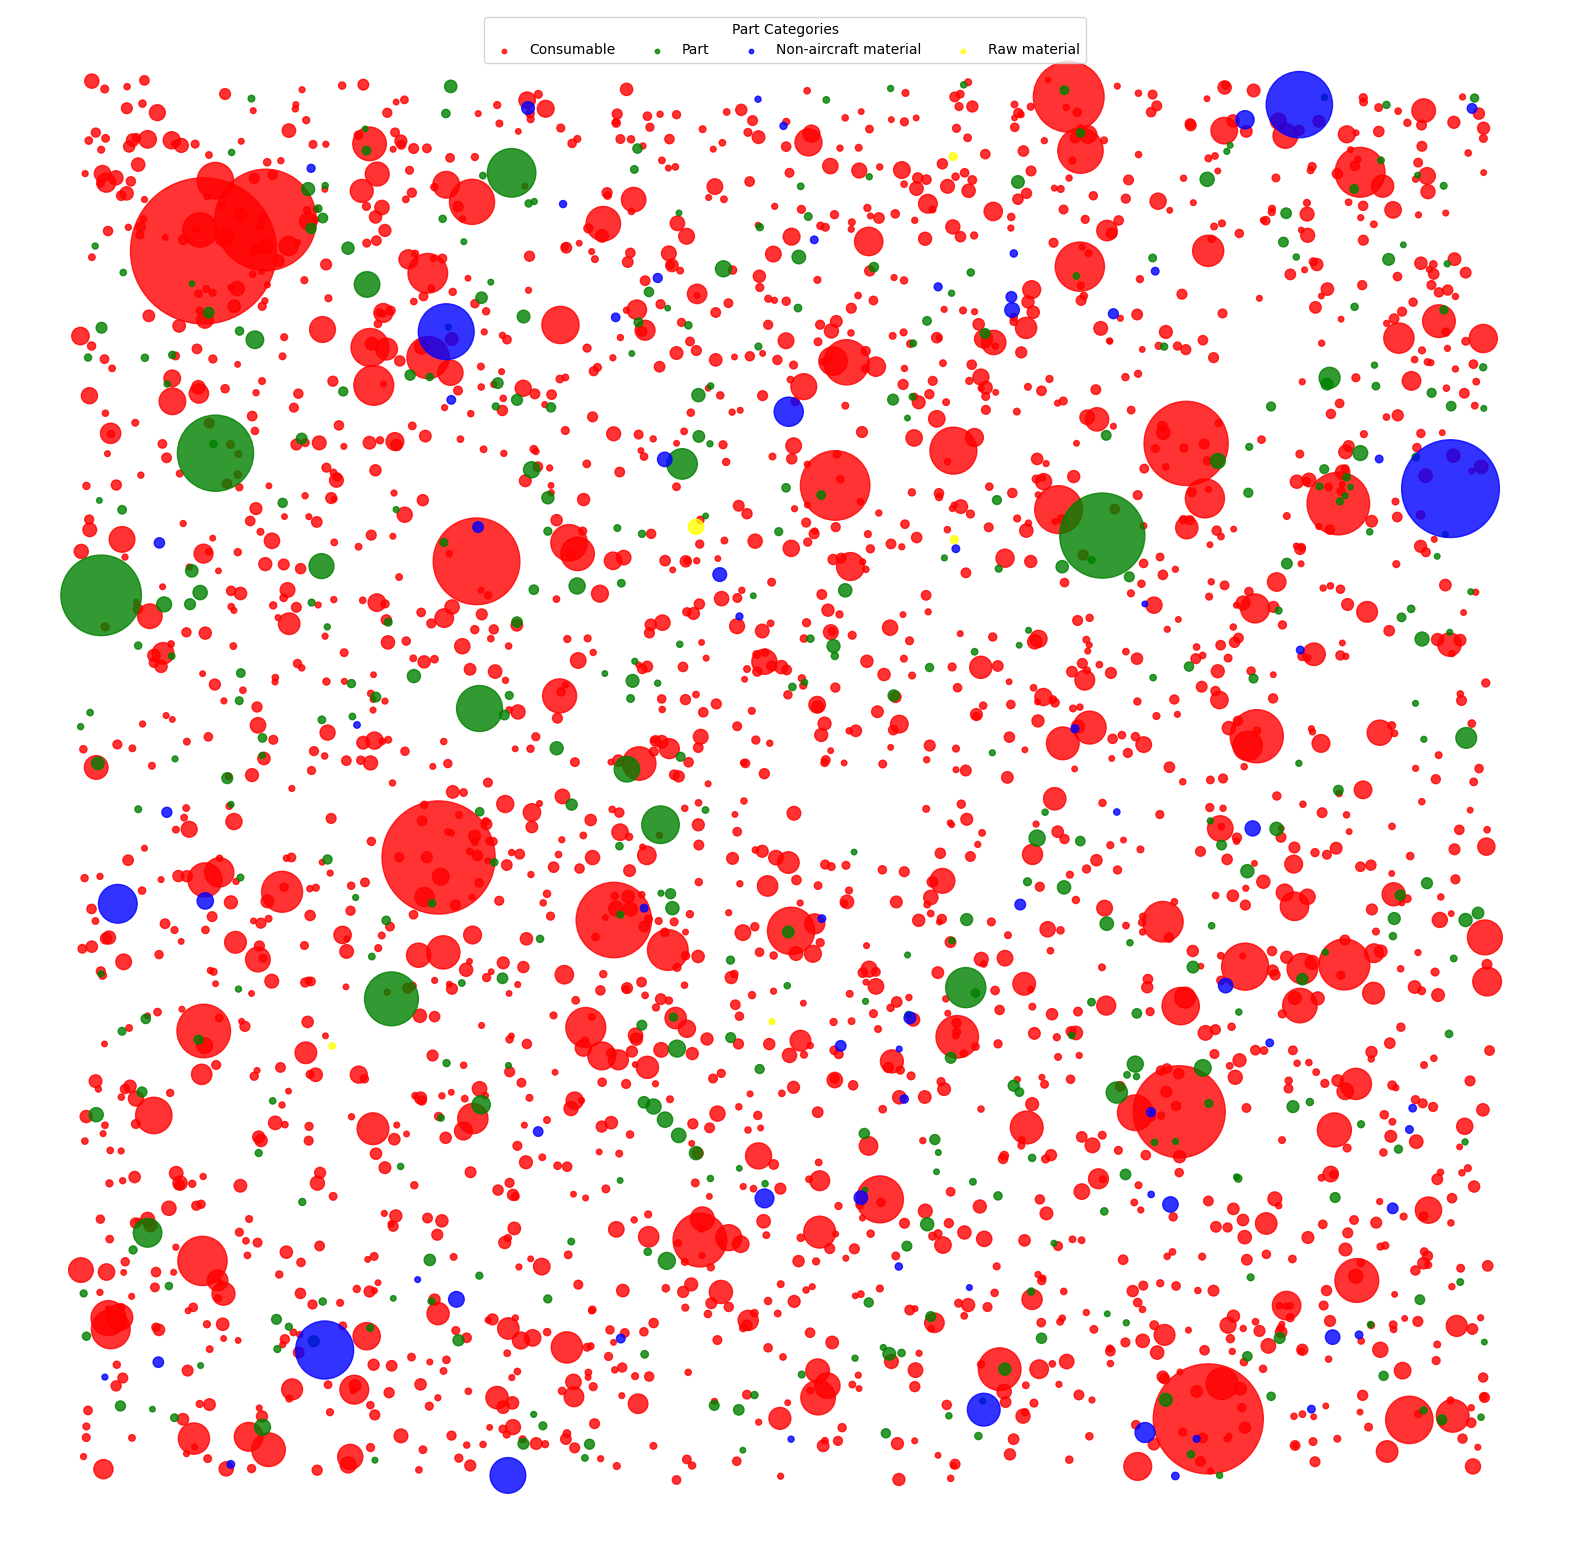

In [13]:
pos=nx.random_layout(G) # nodes are placed at random in 2-dimensional space

fig, ax = plt.subplots(figsize=(20,20))
for category, color in color_map.items():
    category_nodes = [node for node in G.nodes() if G.nodes[node]["category"] == category]
    size_nodes=[G.nodes[node]["frequency"] for node in category_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color=color, node_size=size_nodes, label=category, alpha=0.8)

plt.axis("off")
legend = ax.legend(title="Part Categories", loc='upper center', ncol=5)
for handle in legend.legend_handles:
    handle.set_sizes([10])
plt.show()

## 1.3 Edges of parts network

### 1.3.1 Create edges with weights from 'edges.csv'
Every row in the dataframe corresponds to a pickslip.  
The parts that appear in a pickslip (see 'part' column) are adjacent in the graph, i.e., an edge is formed for each distinct pair of pickslip parts.  
The parts adjacent to part $u$ in the graph are called the neighbors of part $u$.   
The column 'edge_freq' corresponds to the number of appearances of a pickslip in the database.  
For example, the pickslip (see row $1$ of df_edges below) which consists of part_8589989186 and part_8589990685	appears $2$ times in the database.   
ATTENTION! These parts may appear (together along with other parts /separately) in other pickslips.

In [14]:
df_edges=pd.read_csv('edges.csv')
df_edges['parts']=df_edges['parts_m'].str.split(',')

In [15]:
df_edges=df_edges[['parts','edge_freq']]
df_edges

parts  edge_freq
0      [part_8589935459, part_8589935945, part_858993...          1
1                     [part_8589989186, part_8589990685]          2
2      [part_8589944781, part_8589944787, part_858994...          3
3                     [part_8589934897, part_8590209097]          1
4      [part_8589936087, part_8589949124, part_859000...          1
...                                                  ...        ...
25286  [part_8589953413, part_8589957887, part_858997...          2
25287  [part_8589979837, part_8589979838, part_858997...          2
25288                 [part_8589940804, part_8589940806]         10
25289                 [part_8590096130, part_8590275520]          1
25290                 [part_8589934974, part_8589935193]          9

[25291 rows x 2 columns]

### 1.3.2 Compute edge weights. Add weighted edges to graph
Parts $u$, $v$ are connected with an edge of weight $w$, if $u$ and $v$ co-appear in $w$ pickslips

In [16]:
for index, row in tqdm(df_edges.iterrows()):
    edgelist = row["parts"]
    edge_freq = row["edge_freq"]
    for i in range(len(edgelist)):
      for j in range(i+1,len(edgelist)): #no selfedges
        if (edgelist[i],edgelist[j]) in G.edges() and edgelist[i] in G.nodes() and edgelist[j] in G.nodes():
          G[edgelist[i]][edgelist[j]]['weight']+=edge_freq
        elif (edgelist[i],edgelist[j]) not in G.edges() and edgelist[i] in G.nodes() and edgelist[j] in G.nodes():
          G.add_edge(edgelist[i], edgelist[j], weight=edge_freq)

25291it [00:05, 4493.94it/s]


In [17]:
df_edges_new = nx.to_pandas_edgelist(G)

In [18]:
b=dict(G.edges())
print('Number of edges:',len(b))
df_edges_new.sort_values(by=['weight'],ascending=False)

Number of edges: 77611


source           target  weight
76872  part_8589934694  part_8589934678    5211
56230  part_8589935129  part_8589935130    3864
56228  part_8589935129  part_8589935118    3837
63120  part_8589935118  part_8589935130    3833
56227  part_8589935129  part_8589934989    2524
...                ...              ...     ...
43639  part_8589934789  part_8589935296       1
43640  part_8589934789  part_8589936146       1
43641  part_8589934789  part_8589936532       1
43642  part_8589934789  part_8589937370       1
77610  part_8589935306  part_8589934678       1

[77611 rows x 3 columns]

### 1.3.3 Very weak edges: Edges with weight $\leq$ 1

In [19]:
df_edges_new[df_edges_new['weight']<=1].sort_values(by=['weight'],ascending=False)

source           target  weight
4      part_8589934963  part_8589936421       1
51177  part_8589940170  part_8589938144       1
51170  part_8589957250  part_8589935306       1
51171  part_8589957250  part_8589947011       1
51172  part_8589957250  part_8589937963       1
...                ...              ...     ...
25280  part_8589937269  part_8589938382       1
25281  part_8589937269  part_8589941473       1
25283  part_8589937269  part_8589940028       1
25284  part_8589937269  part_8589940651       1
77610  part_8589935306  part_8589934678       1

[39368 rows x 3 columns]

In [20]:
frequency_counts = df_edges_new['weight'].value_counts()
c=dict(frequency_counts)
c={key: c[key] for key in sorted(c)}

# key: number of coappearences
# value: number of edges with the corresponding key value (two parts coappear in $key$ pickslips)
print(c)
print('There are', c[1], ' pairs of parts that coappear in 1 pickslip.')
print('There are', c[2], ' pairs of parts that coappear in 2 pickslips.')
print('There are', c[3], ' pairs of parts that coappear in 3 pickslips.')

{1: 39368, 2: 10700, 3: 5132, 4: 2705, 5: 1779, 6: 1270, 7: 981, 8: 835, 9: 702, 10: 812, 11: 741, 12: 630, 13: 483, 14: 450, 15: 611, 16: 540, 17: 532, 18: 766, 19: 785, 20: 699, 21: 408, 22: 279, 23: 319, 24: 372, 25: 253, 26: 207, 27: 158, 28: 115, 29: 147, 30: 182, 31: 111, 32: 128, 33: 148, 34: 144, 35: 140, 36: 174, 37: 168, 38: 104, 39: 114, 40: 115, 41: 132, 42: 111, 43: 109, 44: 149, 45: 100, 46: 79, 47: 78, 48: 29, 49: 32, 50: 56, 51: 42, 52: 51, 53: 39, 54: 55, 55: 36, 56: 46, 57: 41, 58: 31, 59: 48, 60: 49, 61: 28, 62: 52, 63: 38, 64: 43, 65: 34, 66: 37, 67: 28, 68: 39, 69: 64, 70: 35, 71: 50, 72: 51, 73: 33, 74: 67, 75: 37, 76: 36, 77: 29, 78: 30, 79: 33, 80: 54, 81: 49, 82: 45, 83: 43, 84: 27, 85: 36, 86: 32, 87: 21, 88: 32, 89: 76, 90: 149, 91: 131, 92: 31, 93: 20, 94: 14, 95: 14, 96: 9, 97: 10, 98: 11, 99: 26, 100: 24, 101: 15, 102: 11, 103: 16, 104: 6, 105: 8, 106: 6, 107: 6, 108: 10, 109: 4, 110: 4, 111: 6, 112: 2, 113: 9, 114: 5, 115: 4, 116: 5, 117: 5, 118: 2, 119: 

### 1.3.4 Remove weak edges using an edge-frequency threshold: Edges corresponding to parts that coappear in less than 'edge-thres' pickslips, are dropped.

#### Node strength before edge deletion: sum of incident edges weight (number of coappearences with other parts)

In [21]:
for node in G.nodes():
  node_strength=0
  pickslip_no=[0]
  for neighbor in G.neighbors(node):
    temp = G[node][neighbor]['weight']
    pickslip_no.append(temp)
    node_strength += temp
  G.nodes[node]['strength']=node_strength
  G.nodes[node]['pickslips']=max(pickslip_no)

In [22]:
edge_thres=5

edges_to_remove = []
for edge in tqdm(G.edges(data=True)):
  if edge[2].get("weight") <= edge_thres:
      edges_to_remove.append((edge[0], edge[1]))

G.remove_edges_from(edges_to_remove)

100%|██████████| 77611/77611 [00:00<00:00, 466655.76it/s]


In [23]:
print('Current graph elements')
print('----------------------')
c=dict(G.nodes())
print('Number of nodes:',len(c))
b=dict(G.edges())
print('Number of edges:',len(b))

Current graph elements
----------------------
Number of nodes: 2813
Number of edges: 17927


### 1.3.5 After deleting weak edges, some nodes become isolated (i.e., have 0 edges). These will be dropped.

In [24]:
# drop nodes with 0 degree
nodes_to_remove = []
deg=dict(G.degree())
for node in tqdm(G.nodes()):
  if deg[node]==0:
      nodes_to_remove.append(node)

print('')
print('')
print(len(nodes_to_remove),' nodes will be dropped due weak ties.')
node_name=[]
node_frequency=[]
node_type=[]
node_strength=[]
node_pickslips=[]
for n in nodes_to_remove:
  node_name.append(n)
  node_frequency.append(G.nodes[n]['frequency'])
  node_type.append(G.nodes[n]['category'])
  node_strength.append(G.nodes[n]['strength'])
  node_pickslips.append(G.nodes[n]['pickslips'])
data=dict()
data={'part':node_name,'frequency':node_frequency,'type':node_type,'strength':node_strength,'max_edge_strength':node_pickslips}
df_remove=pd.DataFrame.from_dict(data)

G.remove_nodes_from(nodes_to_remove)
print('--------------------------------------------------------------')
print('')
print('Dataframe of isolated nodes. Node strength and max edge strength are computed before the deletion of weak edges.')
print('')
df_remove.sort_values(by=['strength'],ascending=False)

100%|██████████| 2813/2813 [00:00<00:00, 541840.51it/s]




638  nodes will be dropped due weak ties.
--------------------------------------------------------------

Dataframe of isolated nodes. Node strength and max edge strength are computed before the deletion of weak edges.



part  frequency        type  strength  max_edge_strength
188  part_8589942281         34  Consumable       335                  5
92   part_8589949099         20  Consumable       326                  5
256  part_8589937385         30  Consumable       321                  5
250  part_8589937396         64  Consumable       304                  4
566  part_8589951840         16  Consumable       290                  4
..               ...        ...         ...       ...                ...
338  part_8590002896         18  Consumable         0                  0
524  part_8589978024         17        Part         0                  0
238  part_8589938449         19        Part         0                  0
80   part_8589942603         33        Part         0                  0
637  part_8590115987         35        Part         0                  0

[638 rows x 5 columns]

## 1.4 Resulting graph

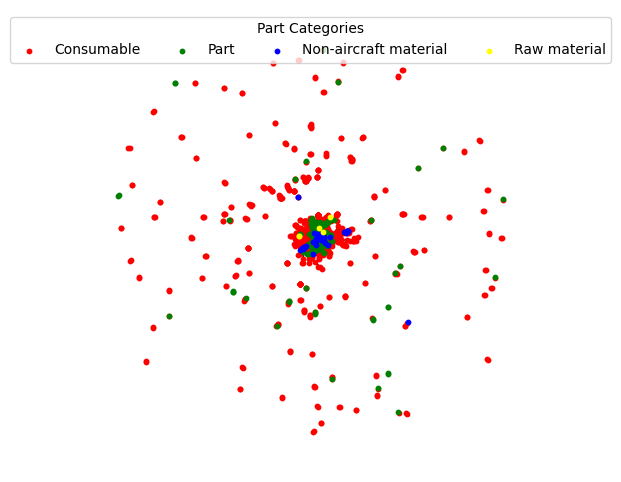

Number of nodes: 2175
Number of edges: 17927


In [25]:
fig, ax = plt.subplots(figsize=(6,6))

pos=nx.spring_layout(G)

for category, color in color_map.items():
    category_nodes = [node for node in G.nodes() if G.nodes[node]["category"] == category]
    size_nodes=[G.nodes[node]["frequency"] for node in category_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color=color, label=category,node_size=10)

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.9)

plt.axis("off")
legend = ax.legend(title="Part Categories", loc='upper center', ncol=5)
for handle in legend.legend_handles:
    handle.set_sizes([10])
plt.show()


c=dict(G.nodes())
print('Number of nodes:',len(c))
b=dict(G.edges())
print('Number of edges:',len(b))

# PART 2: Network properties

## 2.1 Degree distribution
$Degree(u)$: The number of edges incident to $u$ (i.e., the number of parts that co-appear with part $u$)

In [26]:
def degree_hist(G):
  G_degree=G.degree()
  a=[]
  for i,j in G_degree:
      a.append(j)
  plt.hist(a, bins=50, edgecolor='black')
  plt.title("Degree distribution")
  plt.ylabel("Count")
  plt.xlabel("Degree")
  plt.show()
  print("Average Degree:", np.mean(a))
  print("Standard Deviation:", np.std(a))
  print("Minimun Degree:", min(a))
  print("Maximum Degree:", max(a))

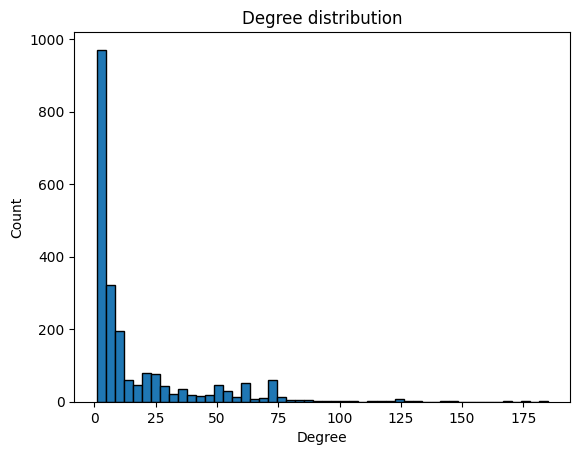

Average Degree: 16.484597701149426
Standard Deviation: 23.728805270194268
Minimun Degree: 1
Maximum Degree: 185


In [27]:
degree_hist(G)

## 2.2 Node Strength distribution
 $Strength(u)$ : The sum of $u$ incident edge weights  (i.e., the number of $u$ co-appearences with other parts)

In [28]:
def strength_hist(G):
  strength=[]
  for node in G.nodes():
    node_strength=0
    for neighbor in G.neighbors(node):
      temp = G[node][neighbor]['weight']
      node_strength += temp
    strength.append(node_strength)

  plt.hist(strength, bins=50, edgecolor='black')
  plt.title("Node Strength distribution")
  plt.ylabel("Count")
  plt.xlabel("Strength")
  plt.show()
  print('')
  print("Average Strength:", np.mean(strength))
  print("Standard Deviation:", np.std(strength))
  print("Minimun Strength:", min(strength))
  print("Maximum Strength:", max(strength))

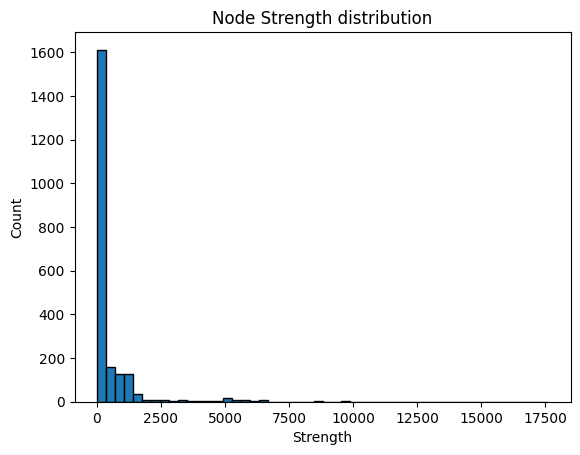


Average Strength: 510.7898850574713
Standard Deviation: 1298.4124709880248
Minimun Strength: 6
Maximum Strength: 17605


In [29]:
strength_hist(G)

# PART 3: Initial partition - Connected Components analysis

Find sets of parts that can be placed independently of each other.

In [30]:
connected_components_size=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
S = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)]

network_info=dict()
cc=[]
dens=[]
for i in range(len(S)):
  network_info[i]=dict()
  # clustering coefficient
  network_info[i]['cc']=nx.average_clustering(S[i])
  cc.append(nx.average_clustering(S[i]))
  # size
  network_info[i]['size']=connected_components_size[i]
  # density
  network_info[i]['density']=2*len(dict(S[i].edges()))/(len(dict(S[i].nodes()))*(len(dict(S[i].nodes()))-1))
  dens.append(2*len(dict(S[i].edges()))/(len(dict(S[i].nodes()))*(len(dict(S[i].nodes()))-1)))

## 3.1 Component Size
Number of nodes in each component

Number_of_connected_components: 139
Connected components size: [1714, 52, 13, 10, 9, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]



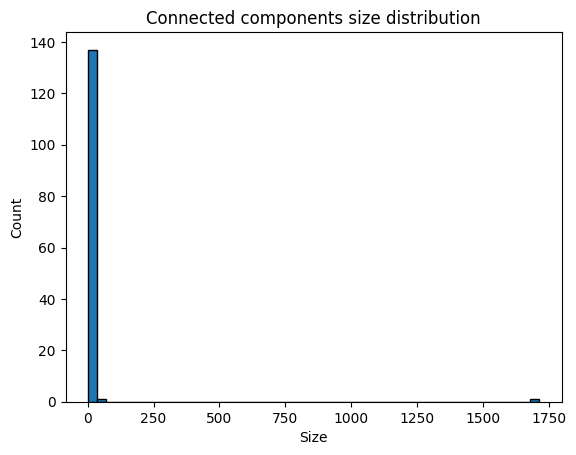


Average Size: 15.647482014388489
Size Median: 2.0
Size Standard Deviation: 144.6426439059581
Minimun Size: 2
Maximum Size: 1714


In [31]:
number_of_connected_components=len(connected_components_size)
print('Number_of_connected_components:',number_of_connected_components)
print('Connected components size:', connected_components_size)
print('')

plt.hist(connected_components_size, bins=50, edgecolor='black')
plt.title("Connected components size distribution")
plt.ylabel("Count")
plt.xlabel("Size")
plt.show()
print('')
print("Average Size:", np.mean(connected_components_size))
print("Size Median:", np.median(connected_components_size))
print("Size Standard Deviation:", np.std(connected_components_size))
print("Minimun Size:", min(connected_components_size))
print("Maximum Size:", max(connected_components_size))

## 3.2 Component Average Clustering Coefficient
The <b>local clustering of a node</b> in the graph is the fraction of triangles that actually exist over all possible triangles in its neighborhood.  

<div>
   <img src="https://www.researchgate.net/profile/Atanu-Chatterjee/publication/287687118/figure/fig3/AS:342293480525826@1458620534096/Figure-shows-the-clustering-coefficient-of-the-blue-node-Ci-in-an-undirected-graph.png" width="600">
</div>

Image reference: https://www.researchgate.net/publication/287687118_Studies_on_the_Structure_and_Dynamics_of_Urban_Bus_Networks_in_Indian_Cities

The <b>average clustering coefficient of the graph</b> is the mean of local clusterings.
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html



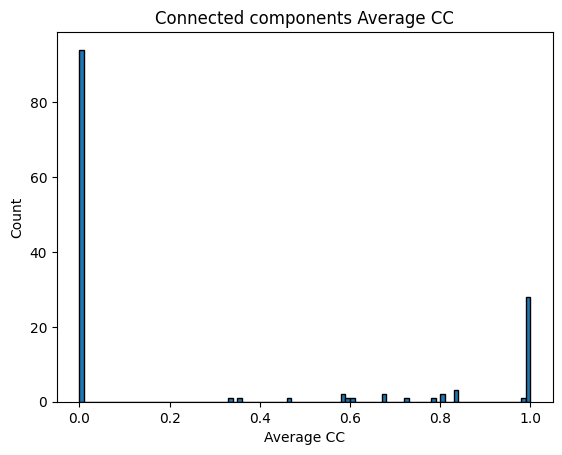


Average CC: 0.2839700108970694
Average CC Standard Deviation: 0.42441427250513614
Component Minimun CC: 0.0
Component Maximum CC: 1.0


In [32]:
plt.hist(cc, bins=100, edgecolor='black')
plt.title("Connected components Average CC")
plt.ylabel("Count")
plt.xlabel("Average CC")
plt.show()
print('')
print("Average CC:", np.mean(cc))
print("Average CC Standard Deviation:", np.std(cc))
print("Component Minimun CC:", min(cc))
print("Component Maximum CC:", max(cc))

## 3.3 Component Density
The density of a graph is defined as the ratio of the total number of edges to the number of all possible edges.

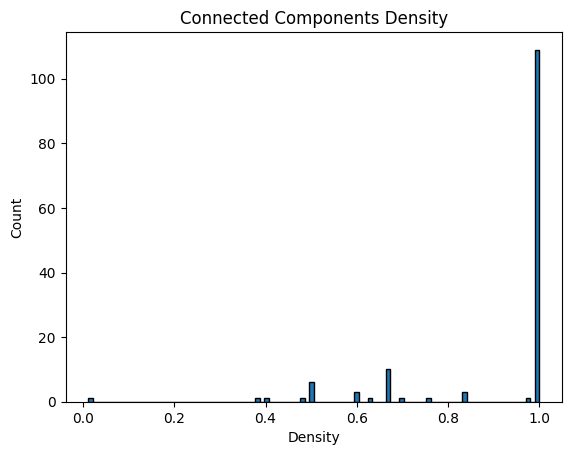


Average Density: 0.9158275944948104
Density Standard Deviation: 0.17934496456924137
Minimun Density: 0.011003098687298244
Maximum Density: 1.0


In [33]:
plt.hist(dens, bins=100, edgecolor='black')
plt.title("Connected Components Density")
plt.ylabel("Count")
plt.xlabel("Density")
plt.show()
print('')
print("Average Density:", np.mean(dens))
print("Density Standard Deviation:", np.std(dens))
print("Minimun Density:", min(dens))
print("Maximum Density:", max(dens))

## 3.4 Visualize connected components

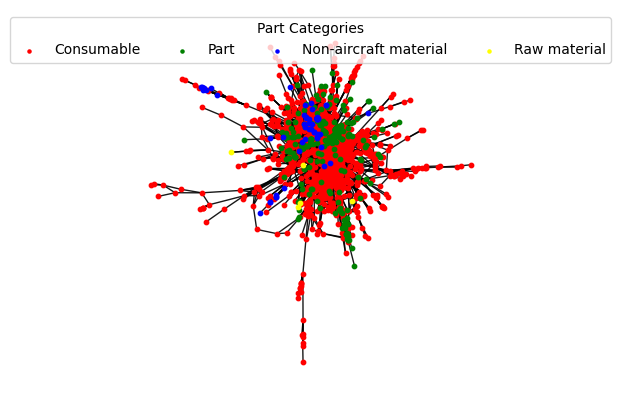

Component 0 : Graph with 1714 nodes and 16153 edges
Size: 1714
Average Clustering Coefficient:  0.6786576297540563
Density: 0.011003098687298244



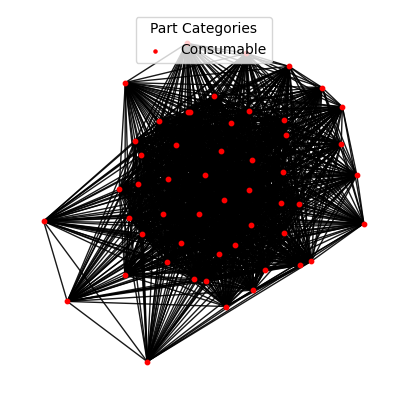

Component 1 : Graph with 52 nodes and 1293 edges
Size: 52
Average Clustering Coefficient:  0.9810859728506792
Density: 0.9751131221719457



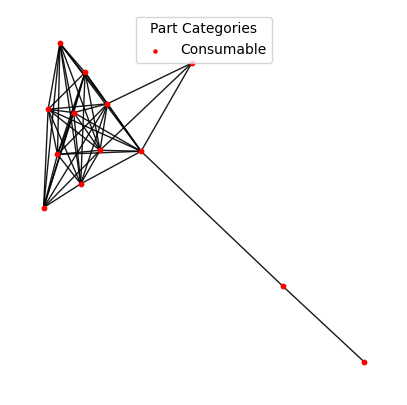

Component 2 : Graph with 13 nodes and 49 edges
Size: 13
Average Clustering Coefficient:  0.7803418803418803
Density: 0.6282051282051282



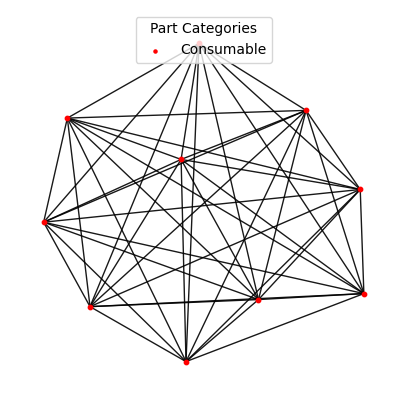

Component 3 : Graph with 10 nodes and 45 edges
Size: 10
Average Clustering Coefficient:  1.0
Density: 1.0



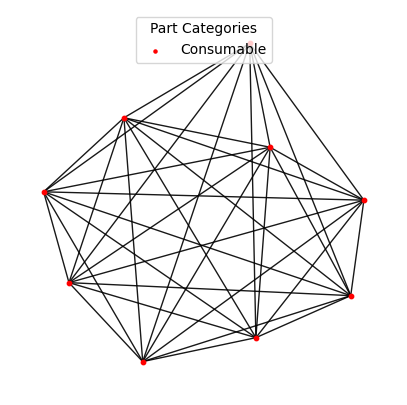

Component 4 : Graph with 9 nodes and 36 edges
Size: 9
Average Clustering Coefficient:  1.0
Density: 1.0



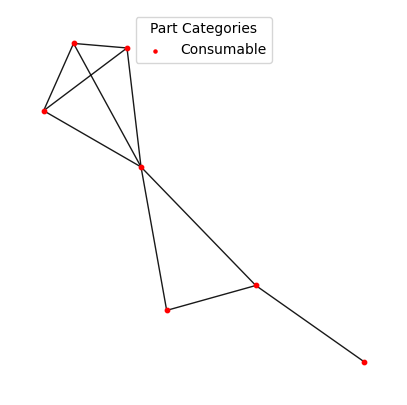

Component 5 : Graph with 7 nodes and 10 edges
Size: 7
Average Clustering Coefficient:  0.6761904761904762
Density: 0.47619047619047616



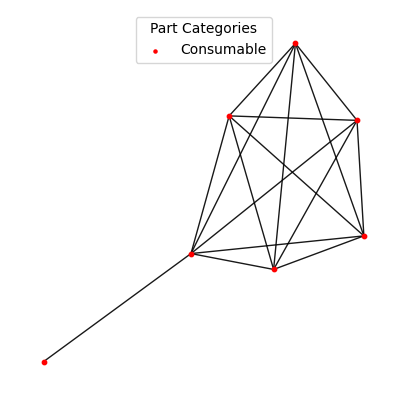

Component 6 : Graph with 7 nodes and 16 edges
Size: 7
Average Clustering Coefficient:  0.8095238095238095
Density: 0.7619047619047619



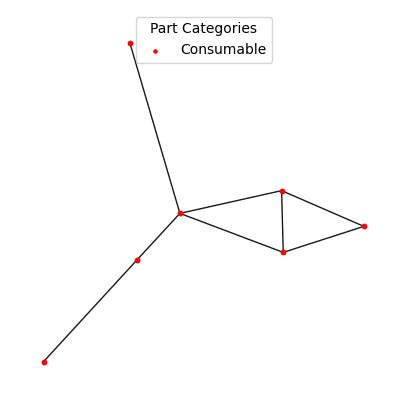

Component 7 : Graph with 7 nodes and 8 edges
Size: 7
Average Clustering Coefficient:  0.3571428571428571
Density: 0.38095238095238093



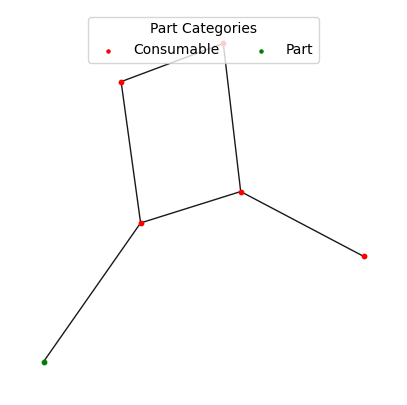

Component 8 : Graph with 6 nodes and 6 edges
Size: 6
Average Clustering Coefficient:  0.0
Density: 0.4



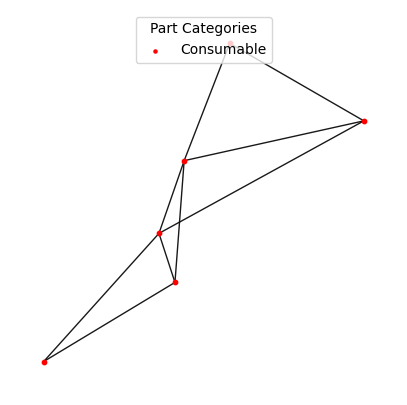

Component 9 : Graph with 6 nodes and 9 edges
Size: 6
Average Clustering Coefficient:  0.7222222222222222
Density: 0.6



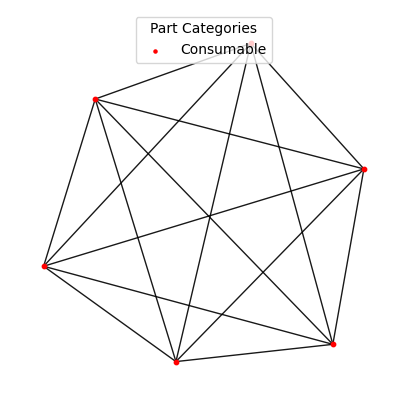

Component 10 : Graph with 6 nodes and 15 edges
Size: 6
Average Clustering Coefficient:  1.0
Density: 1.0



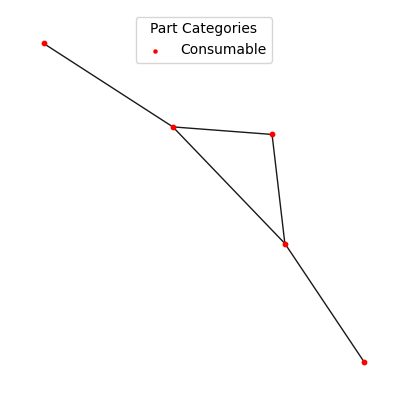

Component 11 : Graph with 5 nodes and 5 edges
Size: 5
Average Clustering Coefficient:  0.3333333333333333
Density: 0.5



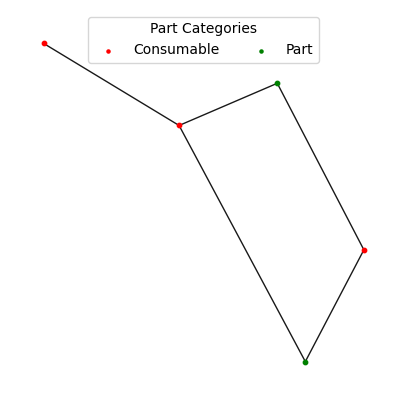

Component 12 : Graph with 5 nodes and 5 edges
Size: 5
Average Clustering Coefficient:  0.0
Density: 0.5



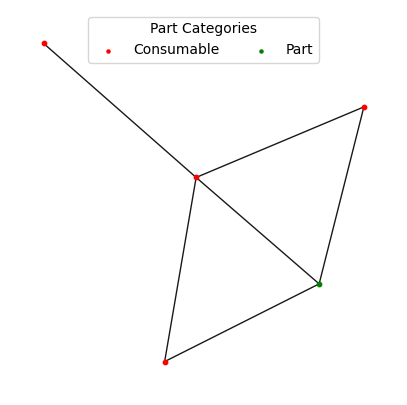

Component 13 : Graph with 5 nodes and 6 edges
Size: 5
Average Clustering Coefficient:  0.5999999999999999
Density: 0.6



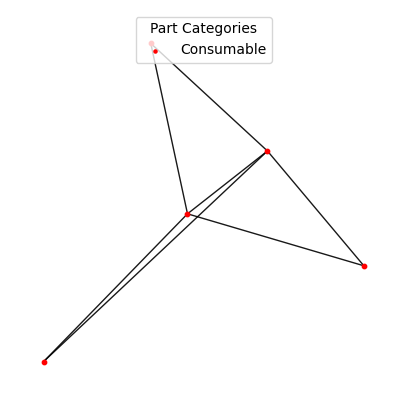

Component 14 : Graph with 5 nodes and 7 edges
Size: 5
Average Clustering Coefficient:  0.8
Density: 0.7



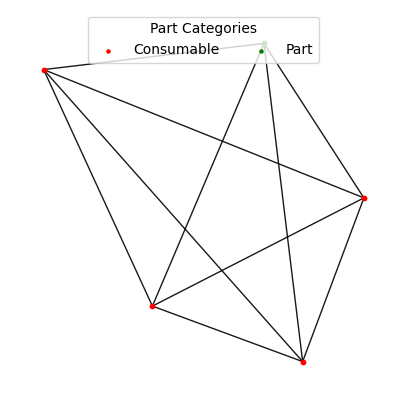

Component 15 : Graph with 5 nodes and 10 edges
Size: 5
Average Clustering Coefficient:  1.0
Density: 1.0



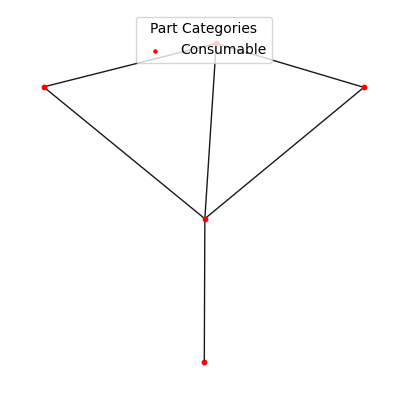

Component 16 : Graph with 5 nodes and 6 edges
Size: 5
Average Clustering Coefficient:  0.6
Density: 0.6



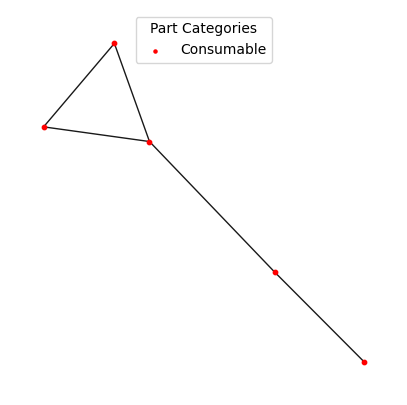

Component 17 : Graph with 5 nodes and 5 edges
Size: 5
Average Clustering Coefficient:  0.4666666666666666
Density: 0.5



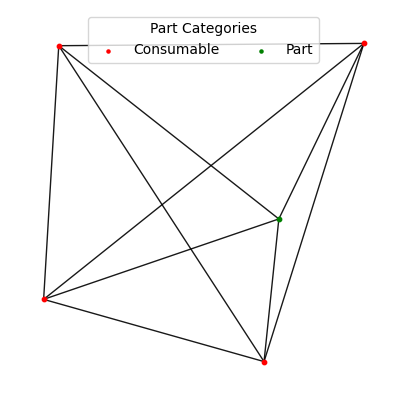

Component 18 : Graph with 5 nodes and 10 edges
Size: 5
Average Clustering Coefficient:  1.0
Density: 1.0



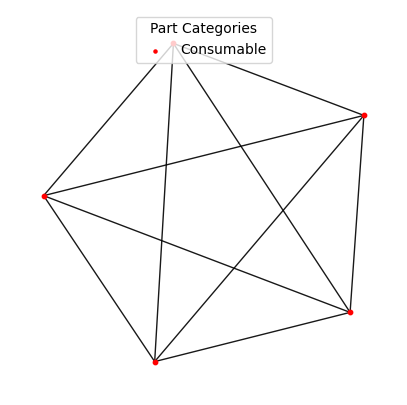

Component 19 : Graph with 5 nodes and 10 edges
Size: 5
Average Clustering Coefficient:  1.0
Density: 1.0



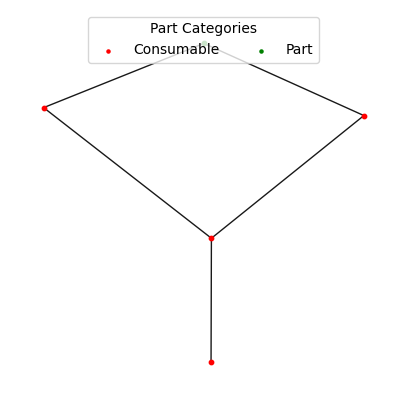

Component 20 : Graph with 5 nodes and 5 edges
Size: 5
Average Clustering Coefficient:  0.0
Density: 0.5



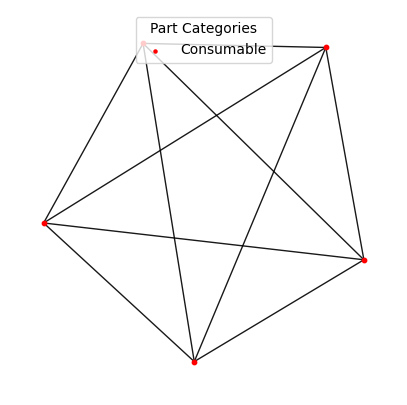

Component 21 : Graph with 5 nodes and 10 edges
Size: 5
Average Clustering Coefficient:  1.0
Density: 1.0



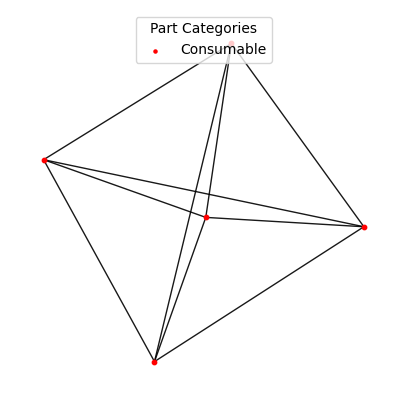

Component 22 : Graph with 5 nodes and 10 edges
Size: 5
Average Clustering Coefficient:  1.0
Density: 1.0



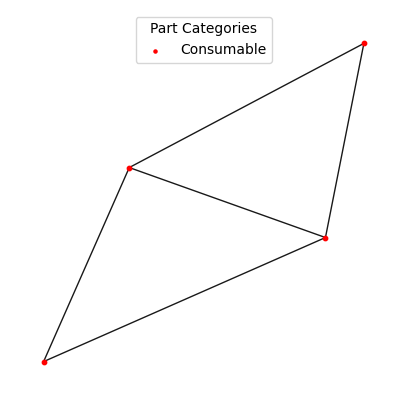

Component 23 : Graph with 4 nodes and 5 edges
Size: 4
Average Clustering Coefficient:  0.8333333333333333
Density: 0.8333333333333334



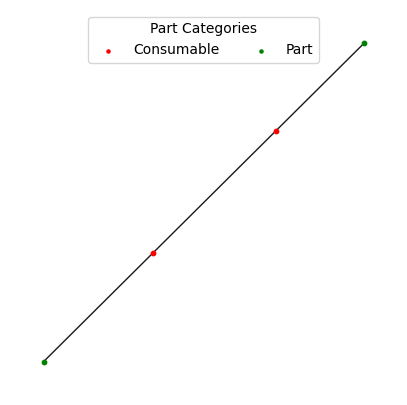

Component 24 : Graph with 4 nodes and 3 edges
Size: 4
Average Clustering Coefficient:  0.0
Density: 0.5



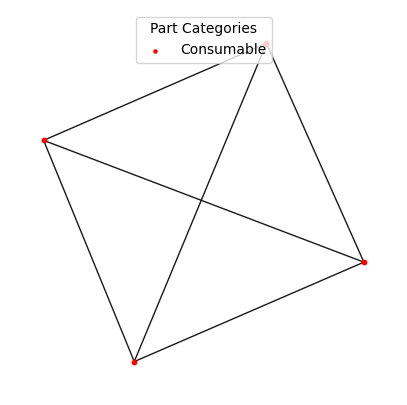

Component 25 : Graph with 4 nodes and 6 edges
Size: 4
Average Clustering Coefficient:  1.0
Density: 1.0



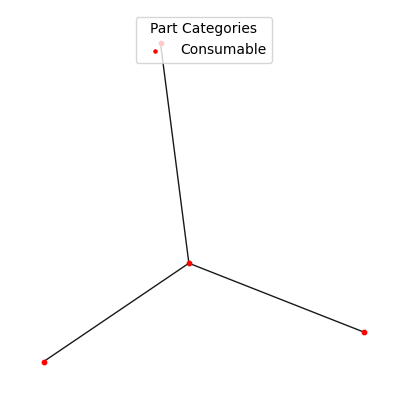

Component 26 : Graph with 4 nodes and 3 edges
Size: 4
Average Clustering Coefficient:  0.0
Density: 0.5



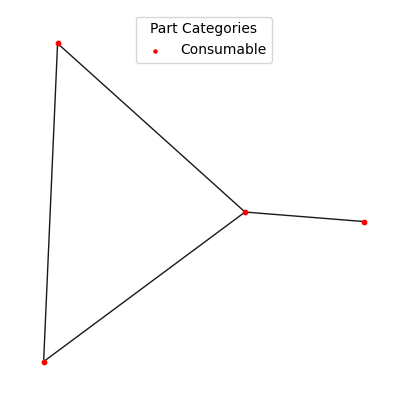

Component 27 : Graph with 4 nodes and 4 edges
Size: 4
Average Clustering Coefficient:  0.5833333333333333
Density: 0.6666666666666666



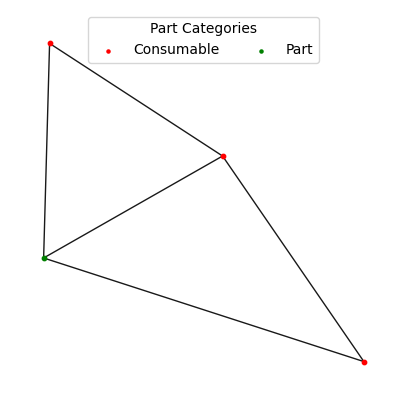

Component 28 : Graph with 4 nodes and 5 edges
Size: 4
Average Clustering Coefficient:  0.8333333333333333
Density: 0.8333333333333334



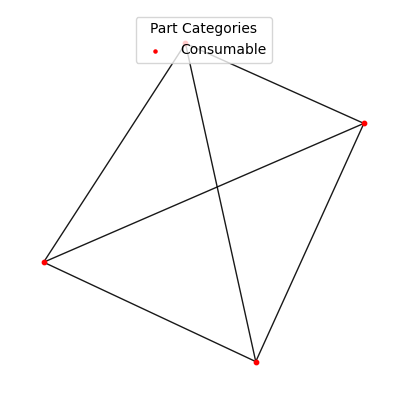

Component 29 : Graph with 4 nodes and 6 edges
Size: 4
Average Clustering Coefficient:  1.0
Density: 1.0



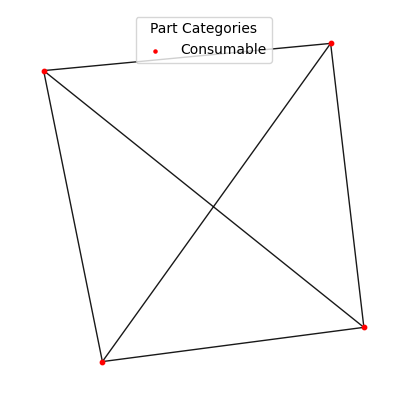

Component 30 : Graph with 4 nodes and 6 edges
Size: 4
Average Clustering Coefficient:  1.0
Density: 1.0



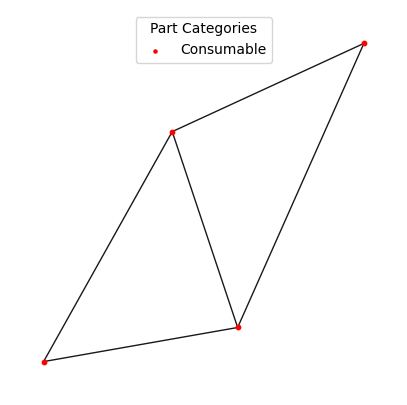

Component 31 : Graph with 4 nodes and 5 edges
Size: 4
Average Clustering Coefficient:  0.8333333333333333
Density: 0.8333333333333334



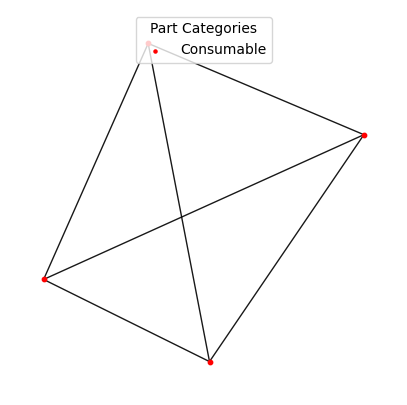

Component 32 : Graph with 4 nodes and 6 edges
Size: 4
Average Clustering Coefficient:  1.0
Density: 1.0



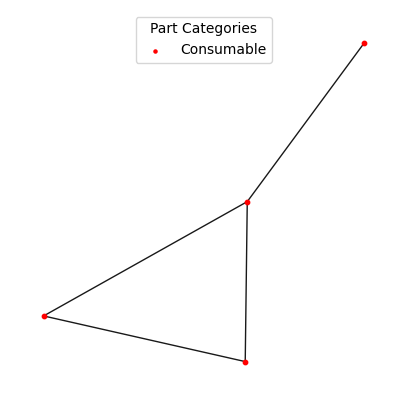

Component 33 : Graph with 4 nodes and 4 edges
Size: 4
Average Clustering Coefficient:  0.5833333333333334
Density: 0.6666666666666666



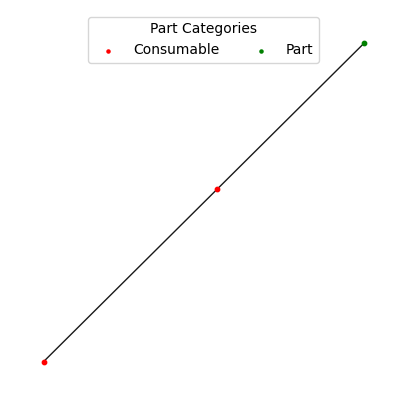

Component 34 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



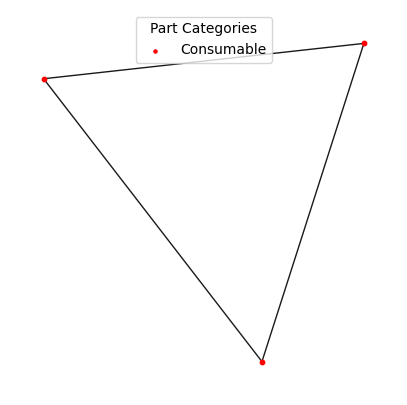

Component 35 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



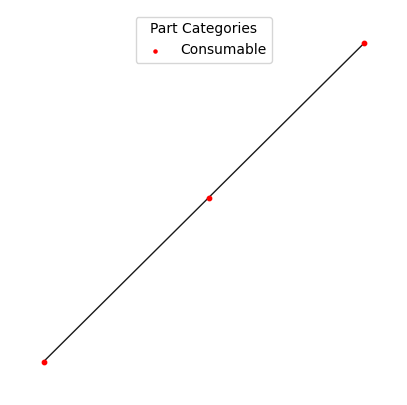

Component 36 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



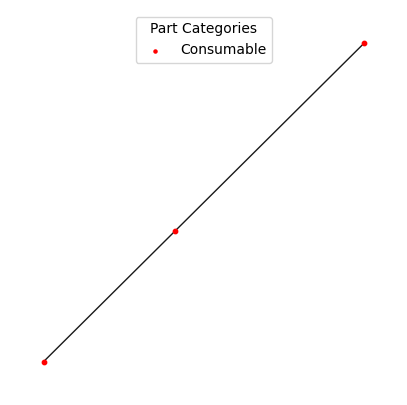

Component 37 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



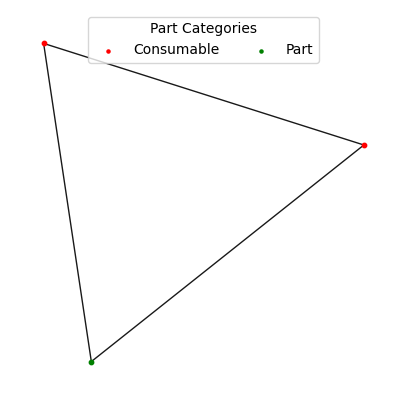

Component 38 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



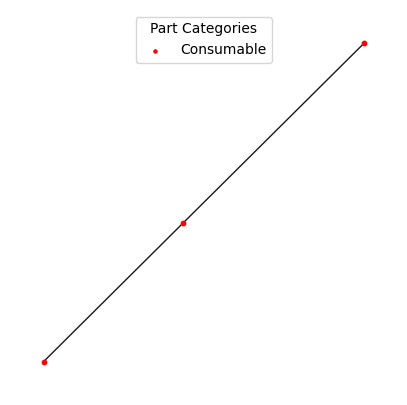

Component 39 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



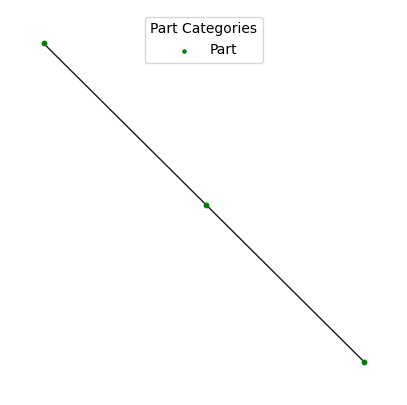

Component 40 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



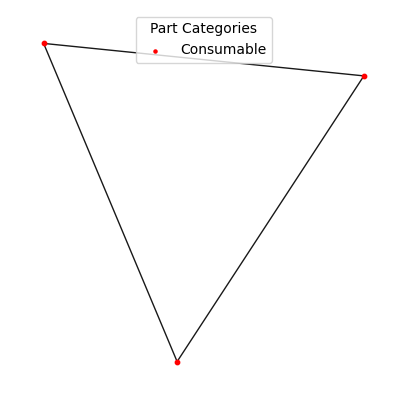

Component 41 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



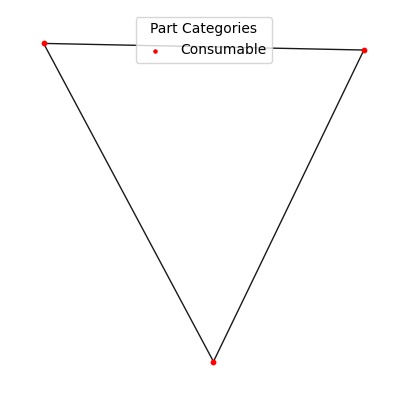

Component 42 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



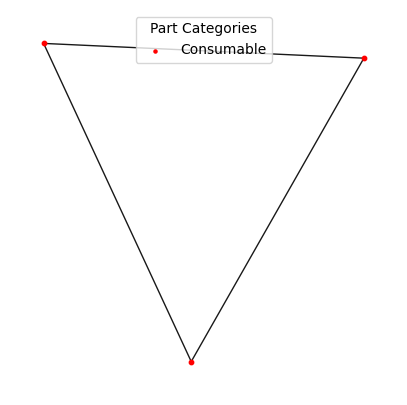

Component 43 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



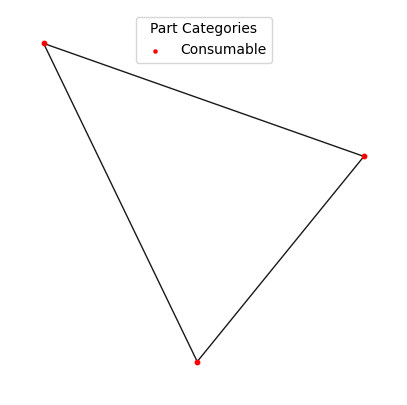

Component 44 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



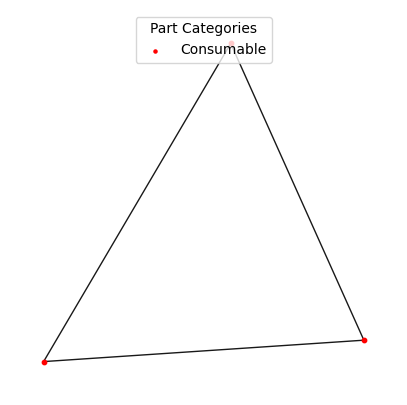

Component 45 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



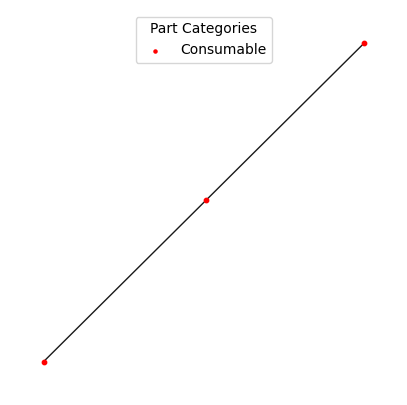

Component 46 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



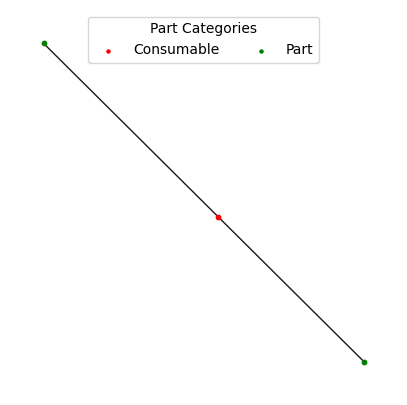

Component 47 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



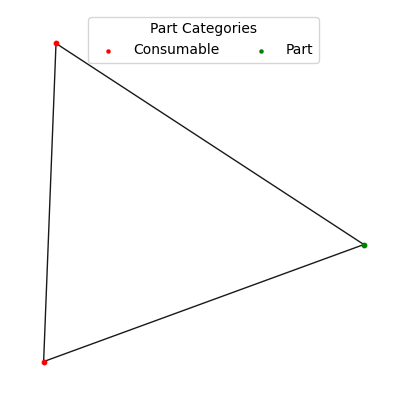

Component 48 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



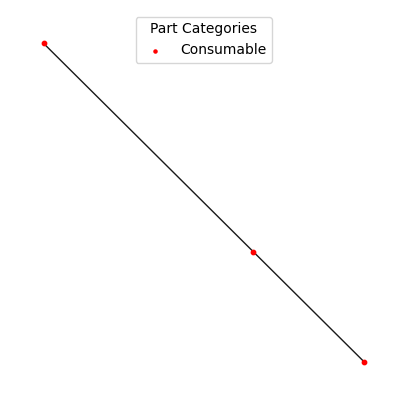

Component 49 : Graph with 3 nodes and 2 edges
Size: 3
Average Clustering Coefficient:  0.0
Density: 0.6666666666666666



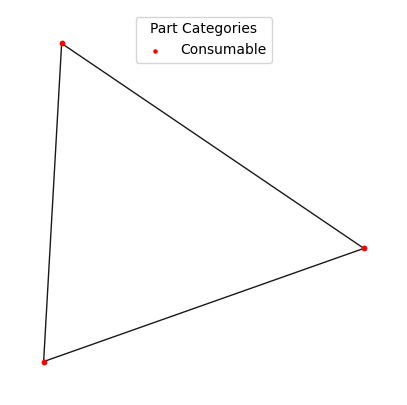

Component 50 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



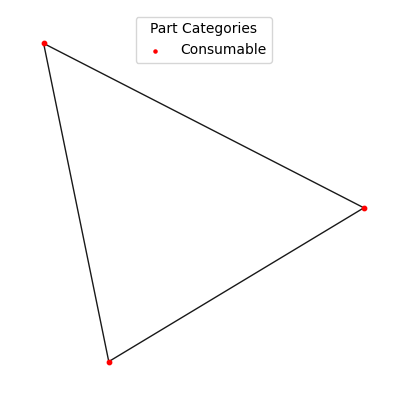

Component 51 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



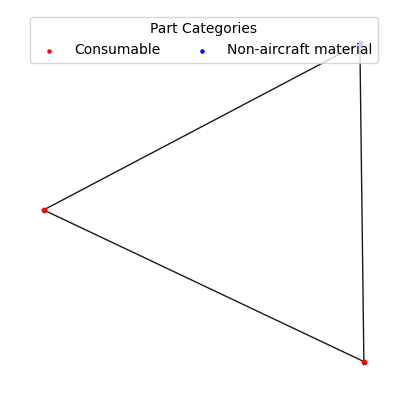

Component 52 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



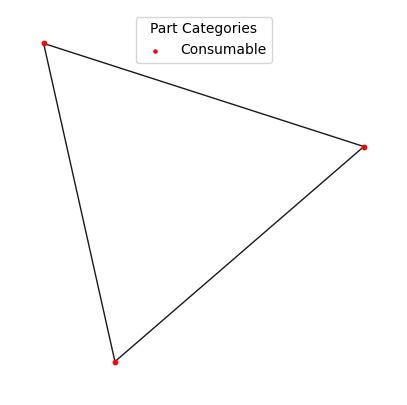

Component 53 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



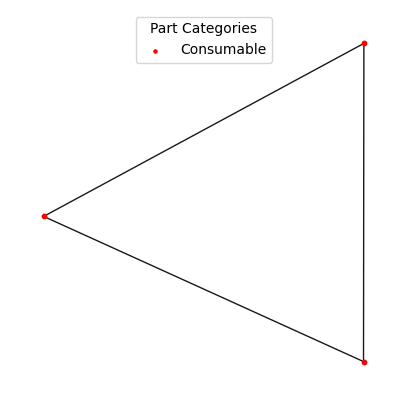

Component 54 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



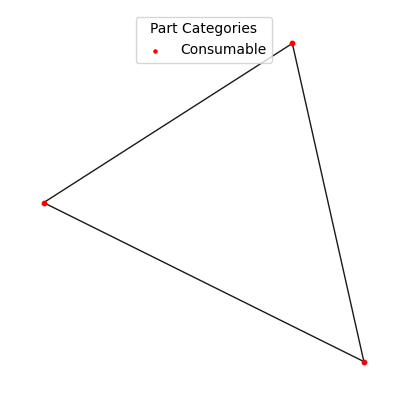

Component 55 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



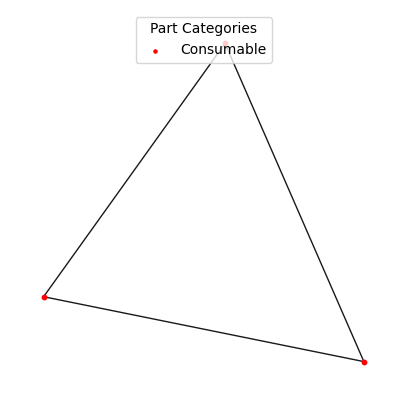

Component 56 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



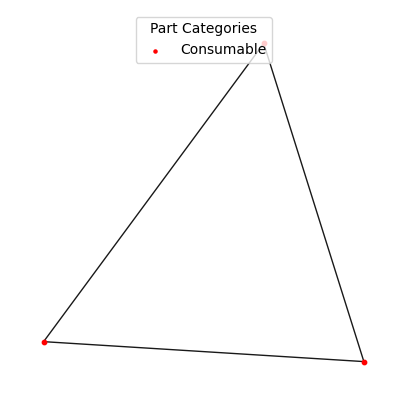

Component 57 : Graph with 3 nodes and 3 edges
Size: 3
Average Clustering Coefficient:  1.0
Density: 1.0



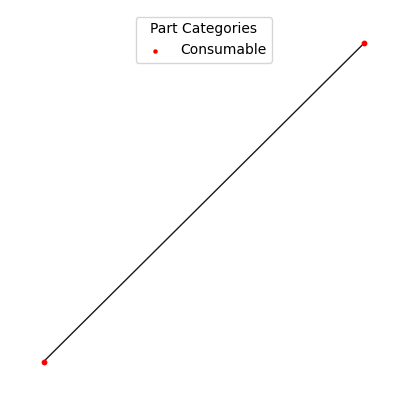

Component 58 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



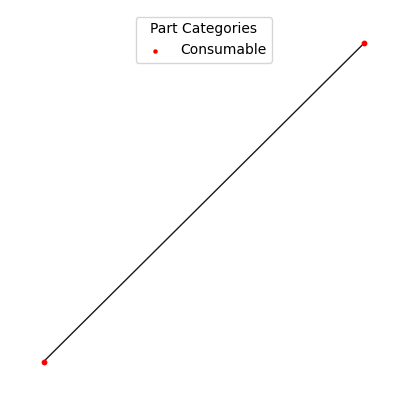

Component 59 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



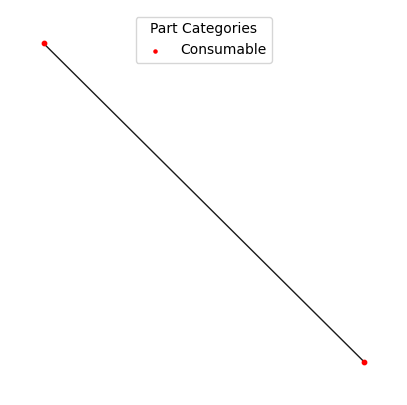

Component 60 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



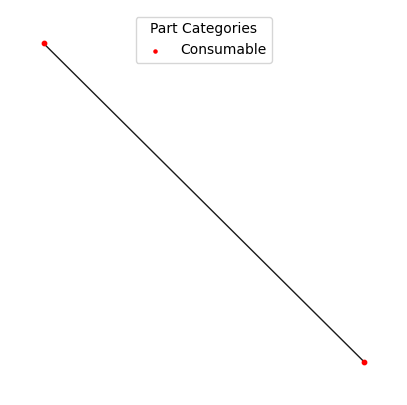

Component 61 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



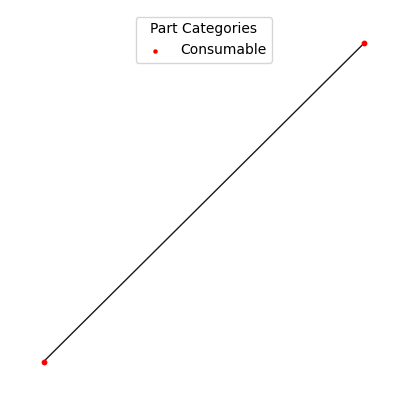

Component 62 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



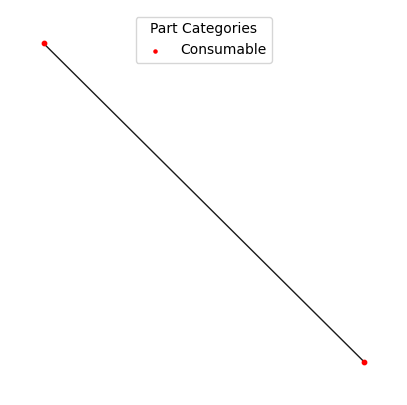

Component 63 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



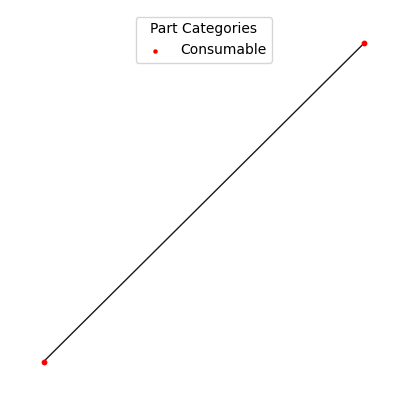

Component 64 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



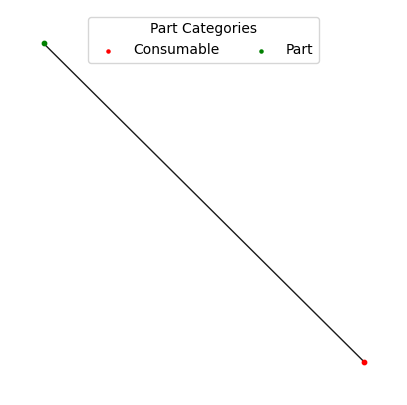

Component 65 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



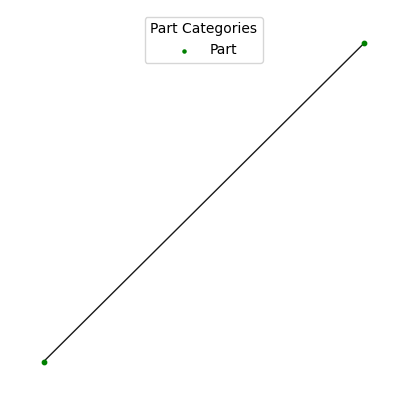

Component 66 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



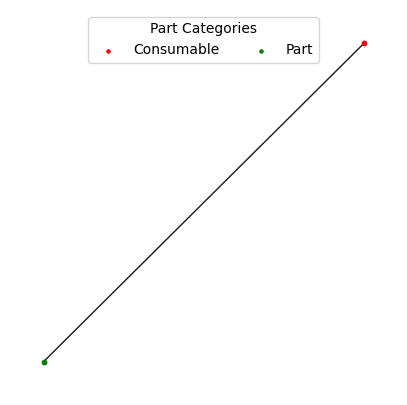

Component 67 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



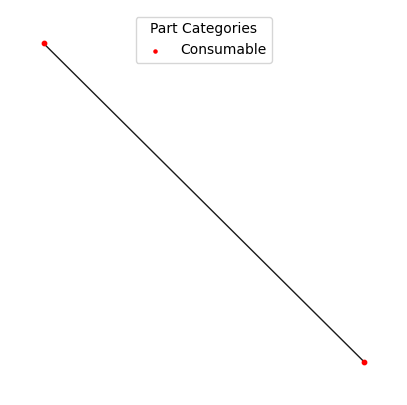

Component 68 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



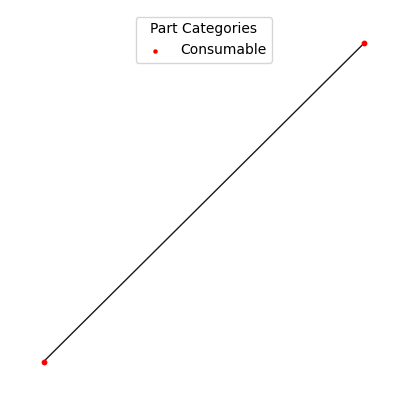

Component 69 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



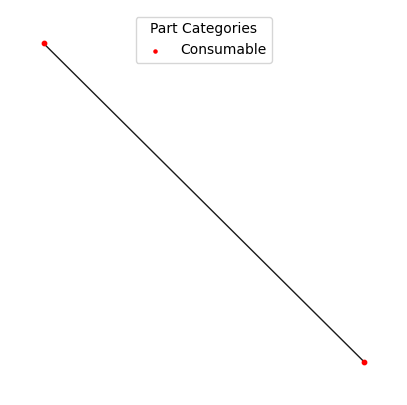

Component 70 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



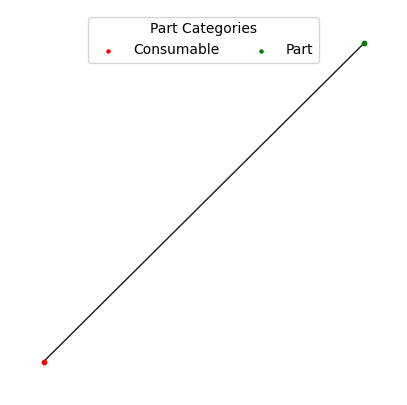

Component 71 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



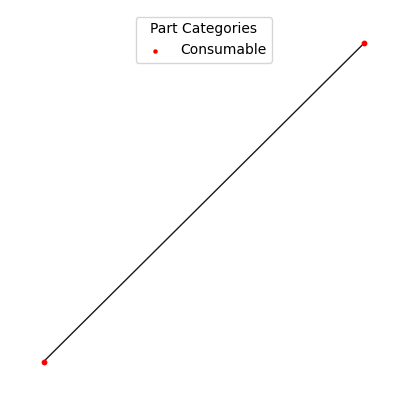

Component 72 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



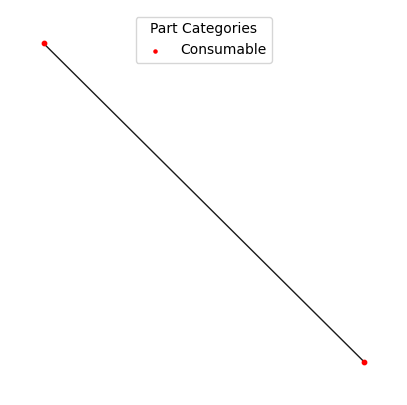

Component 73 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



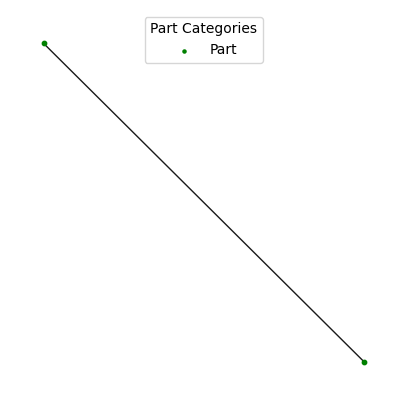

Component 74 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



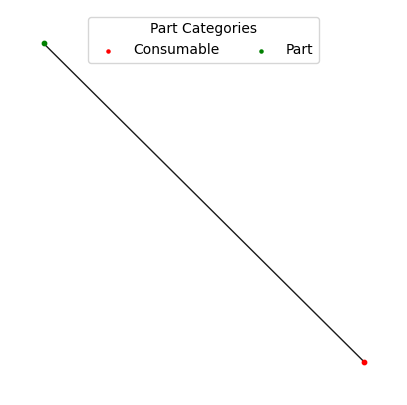

Component 75 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



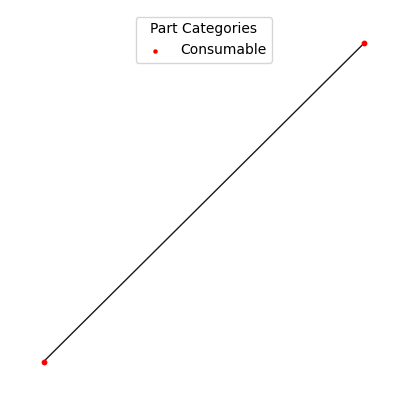

Component 76 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



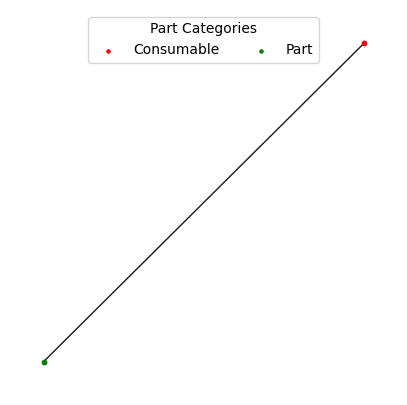

Component 77 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



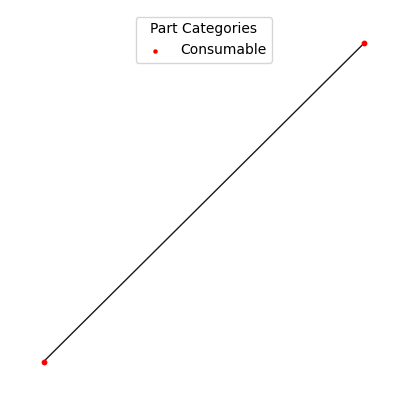

Component 78 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



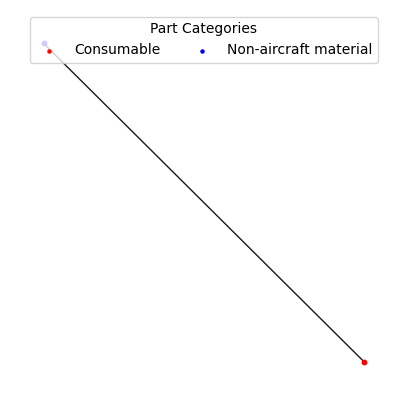

Component 79 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



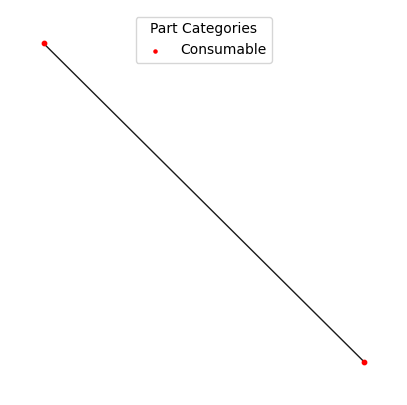

Component 80 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



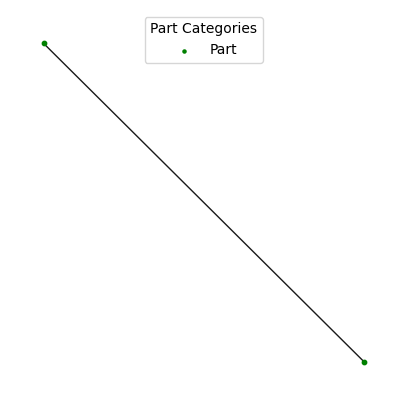

Component 81 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



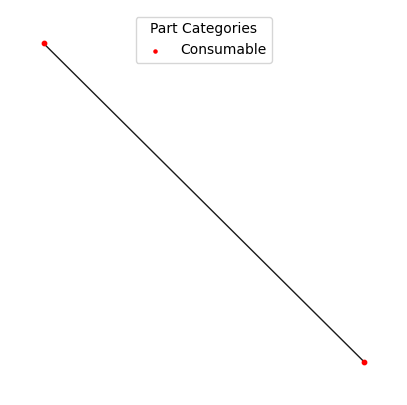

Component 82 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



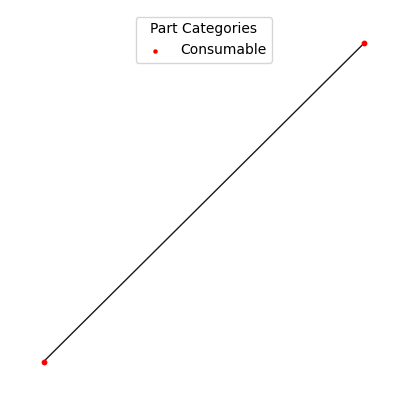

Component 83 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



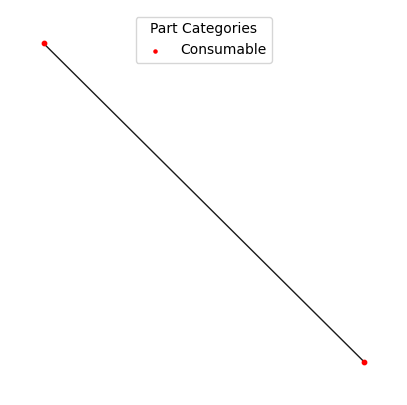

Component 84 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



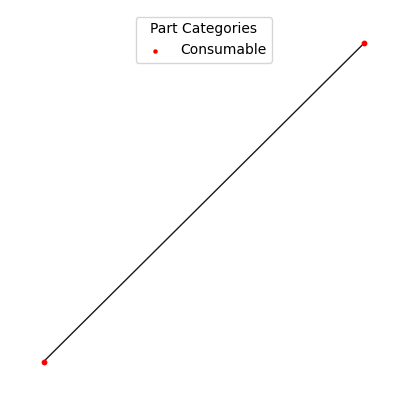

Component 85 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



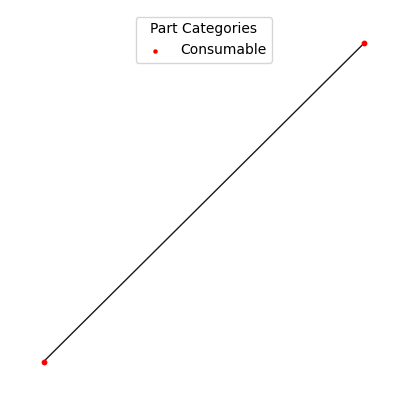

Component 86 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



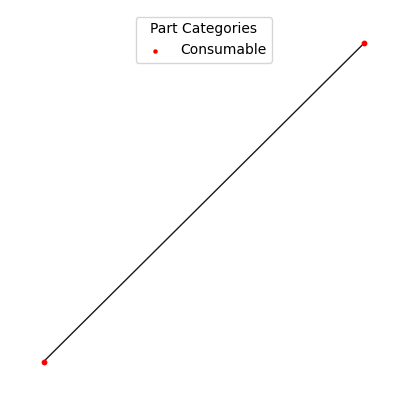

Component 87 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



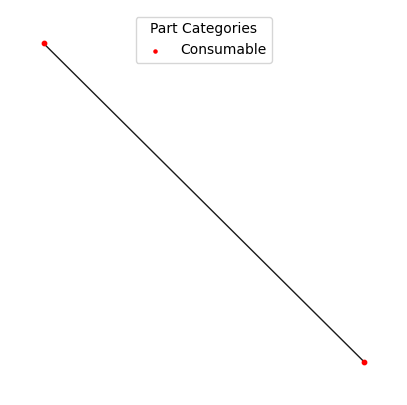

Component 88 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



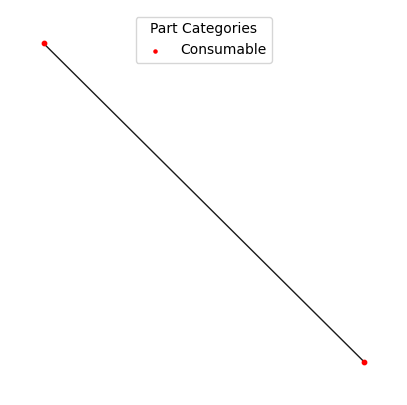

Component 89 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



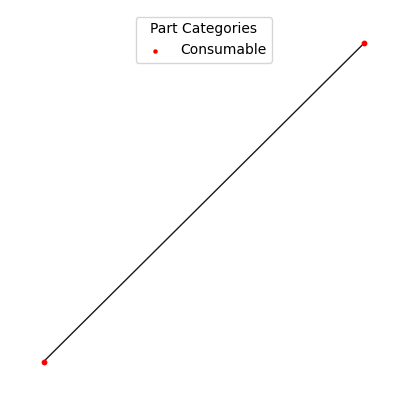

Component 90 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



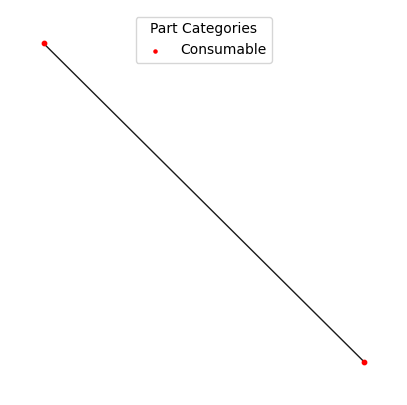

Component 91 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



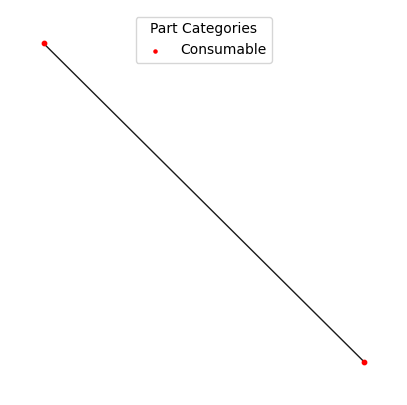

Component 92 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



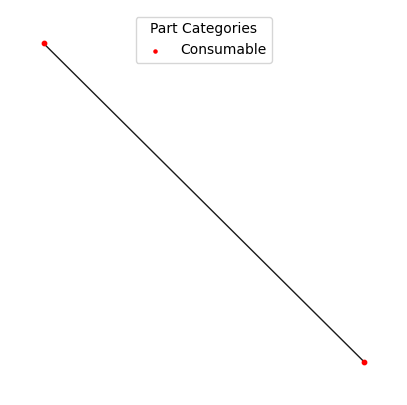

Component 93 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



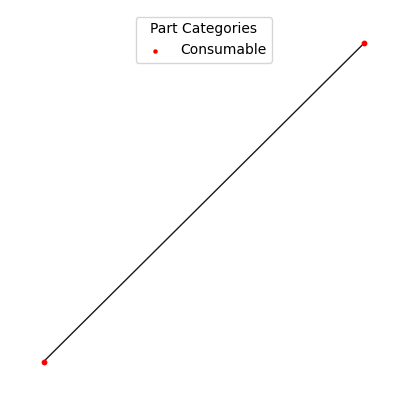

Component 94 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



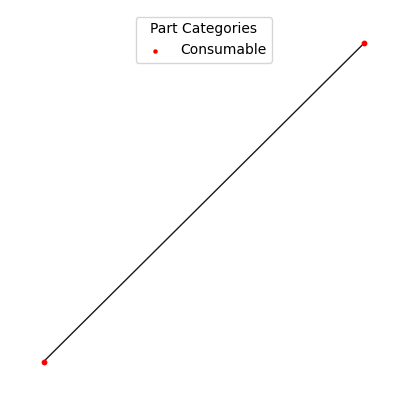

Component 95 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



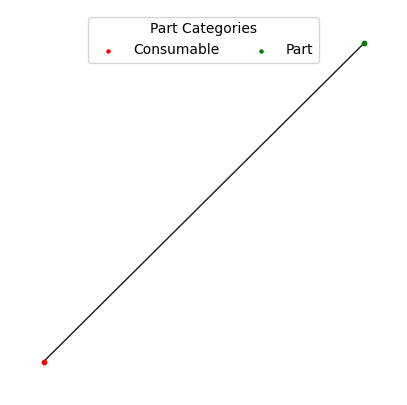

Component 96 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



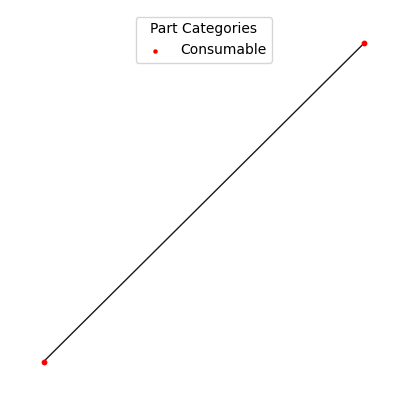

Component 97 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



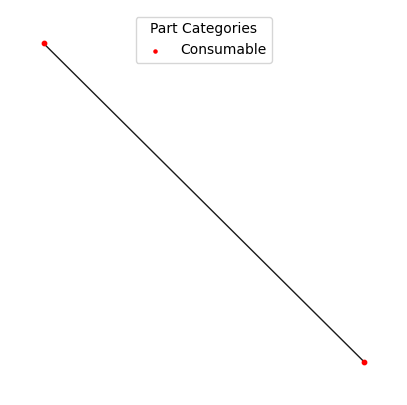

Component 98 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



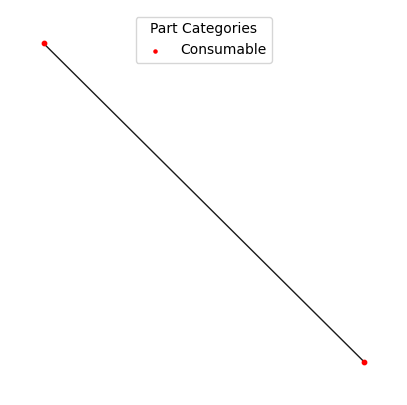

Component 99 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



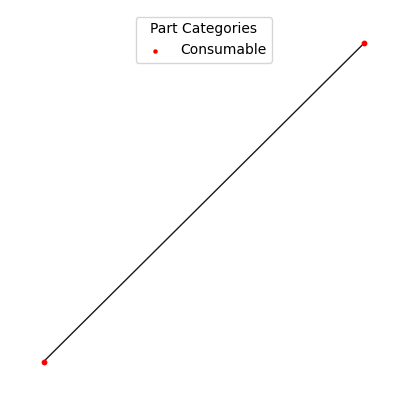

Component 100 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



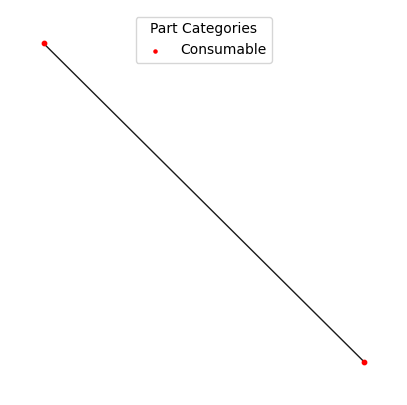

Component 101 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



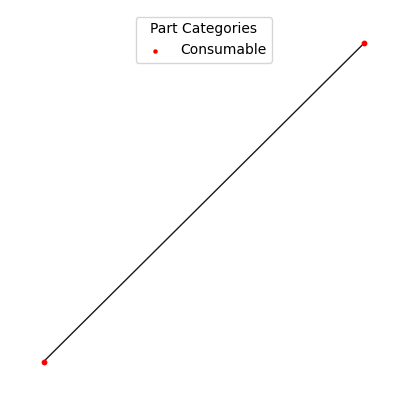

Component 102 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



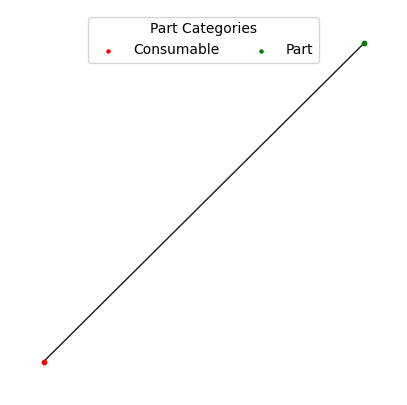

Component 103 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



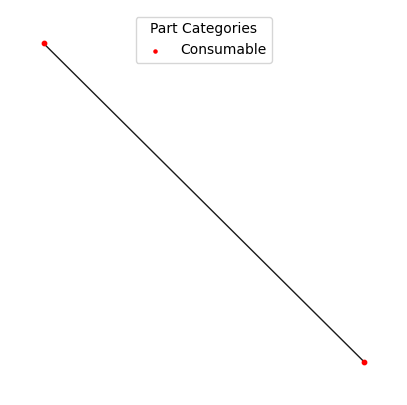

Component 104 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



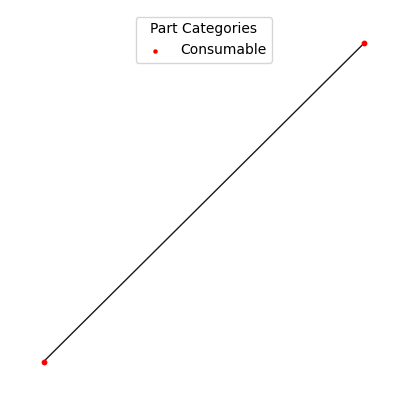

Component 105 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



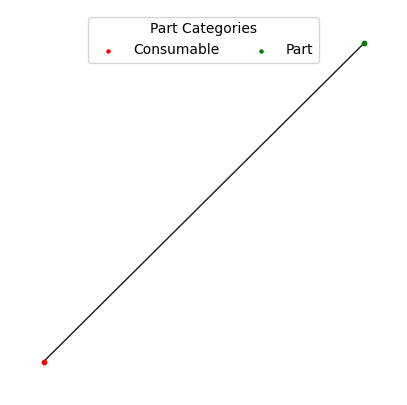

Component 106 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



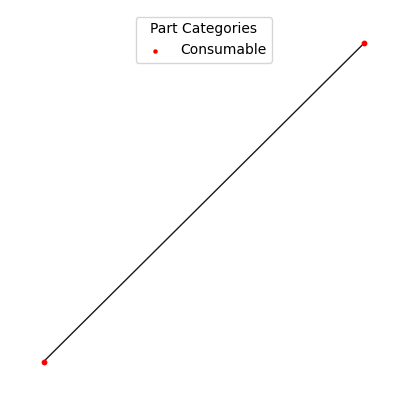

Component 107 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



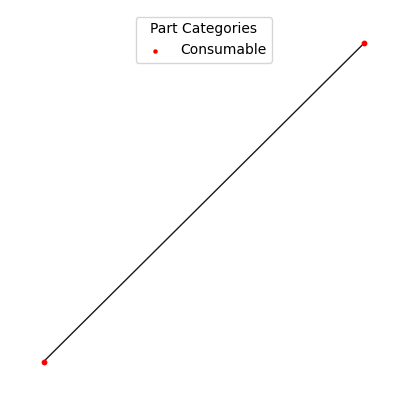

Component 108 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



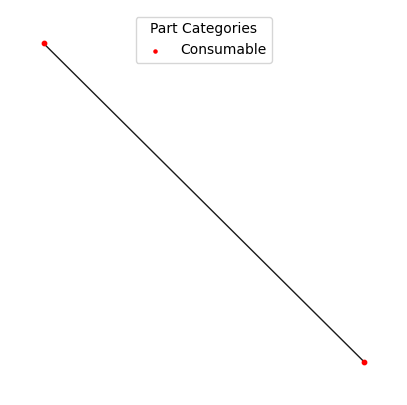

Component 109 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



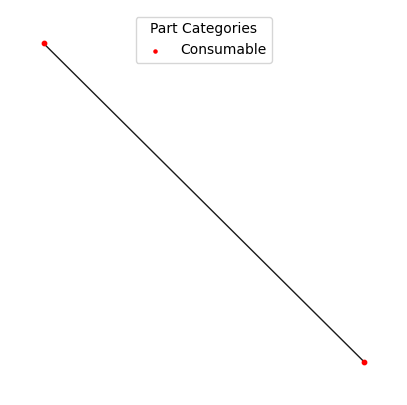

Component 110 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



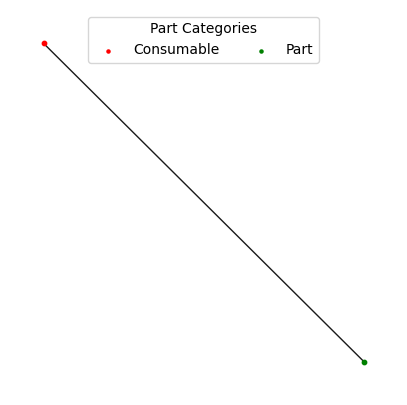

Component 111 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



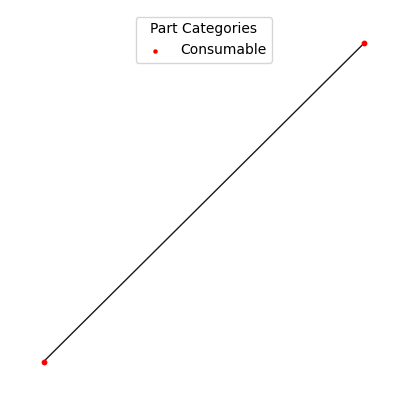

Component 112 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



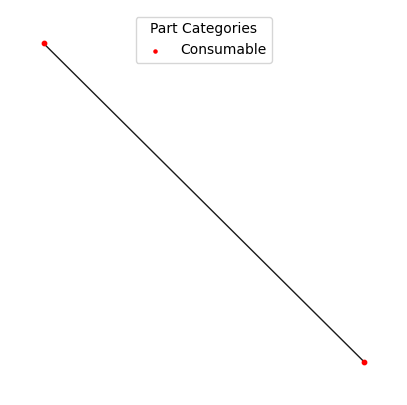

Component 113 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



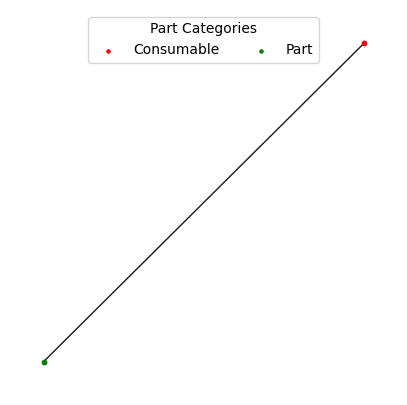

Component 114 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



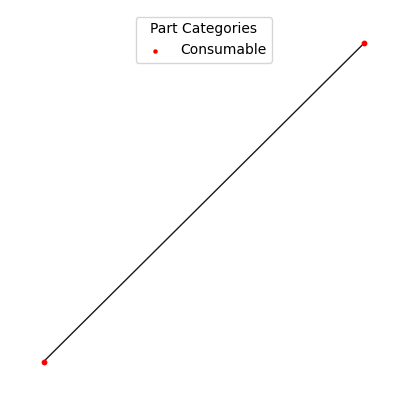

Component 115 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



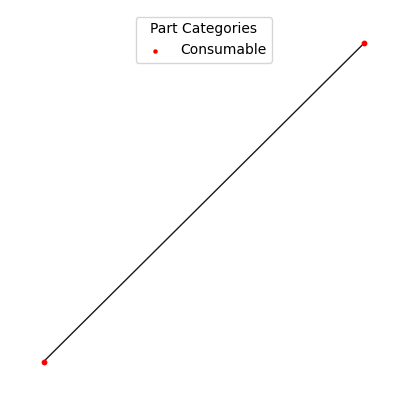

Component 116 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



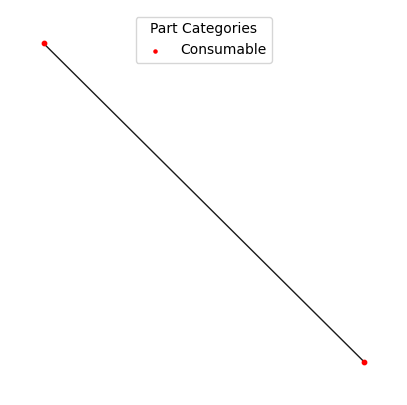

Component 117 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



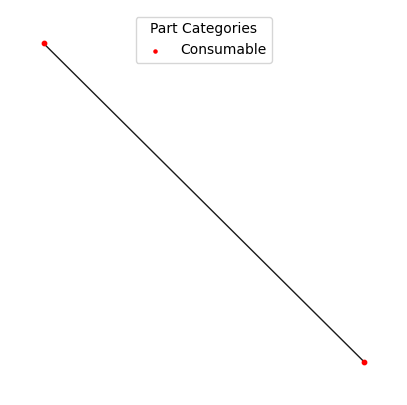

Component 118 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



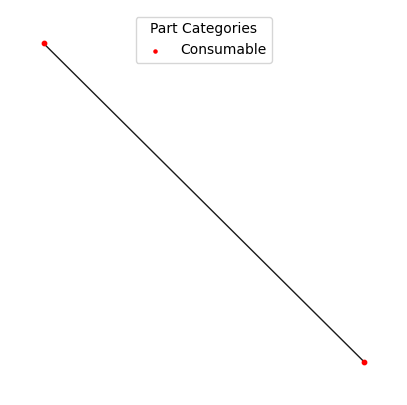

Component 119 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



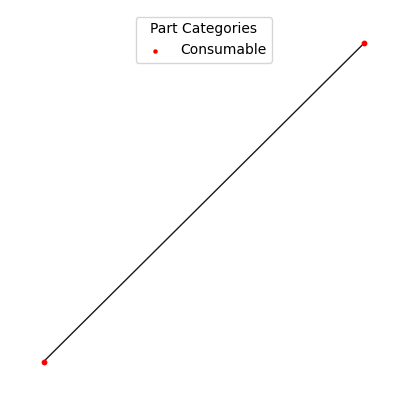

Component 120 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



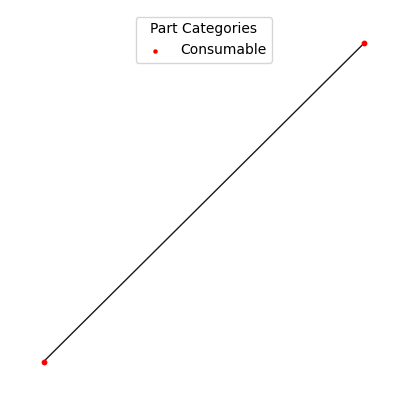

Component 121 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



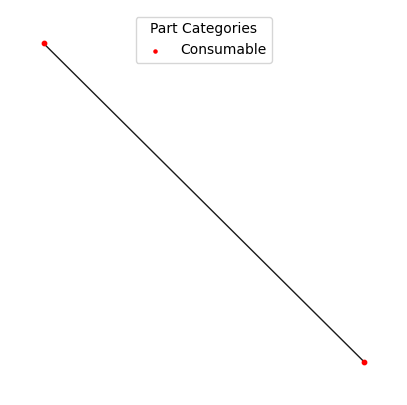

Component 122 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



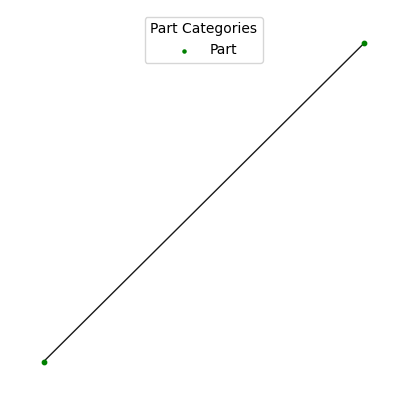

Component 123 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



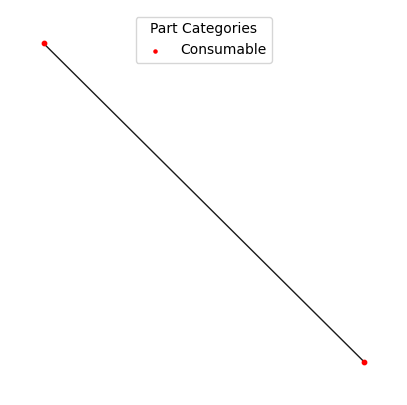

Component 124 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



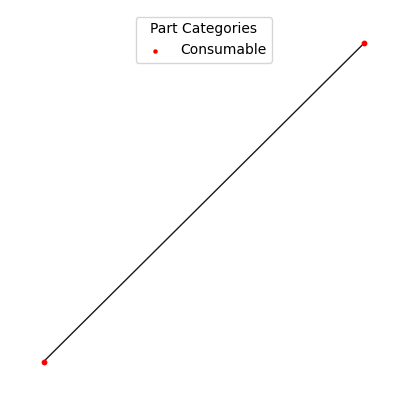

Component 125 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



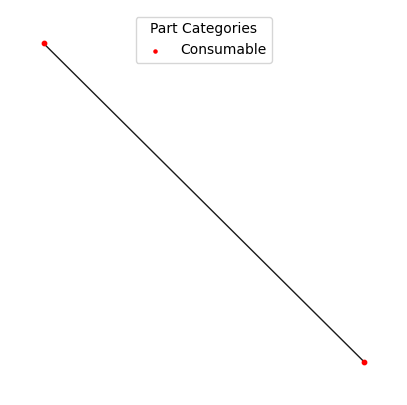

Component 126 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



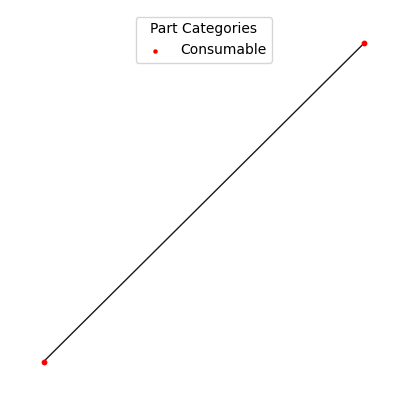

Component 127 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



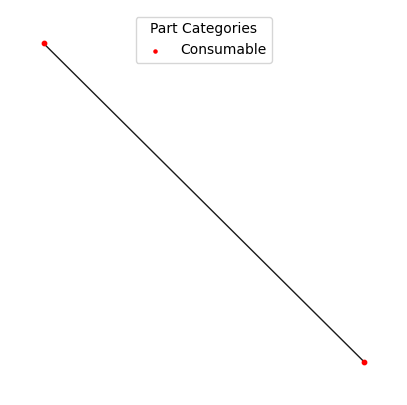

Component 128 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



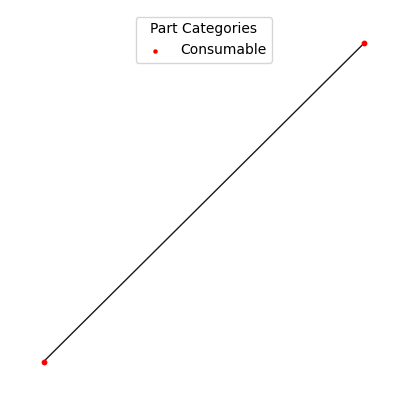

Component 129 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



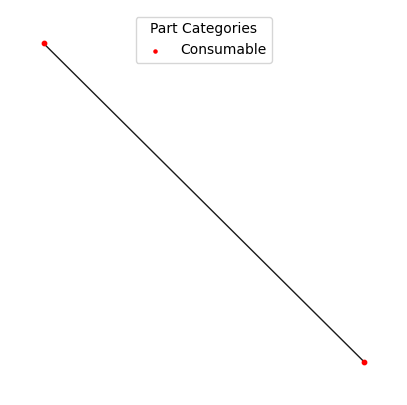

Component 130 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



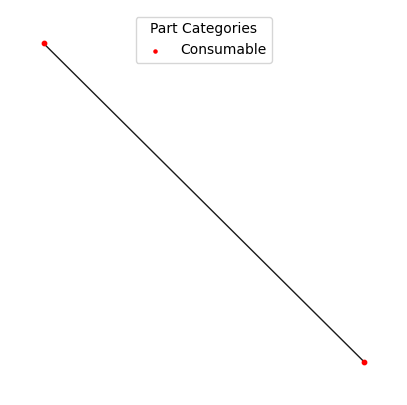

Component 131 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



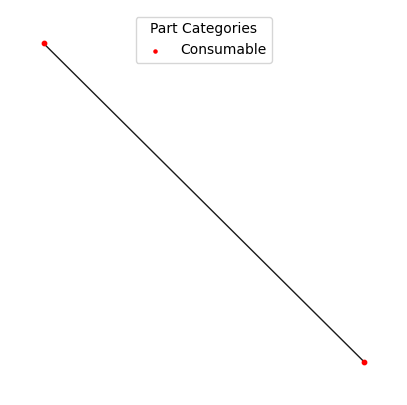

Component 132 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



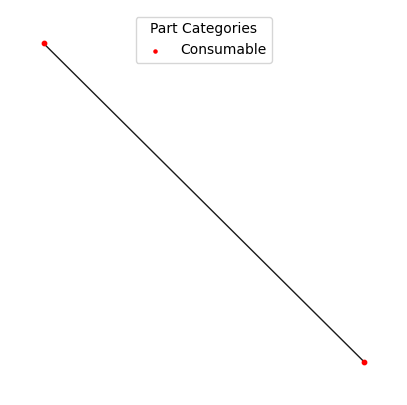

Component 133 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



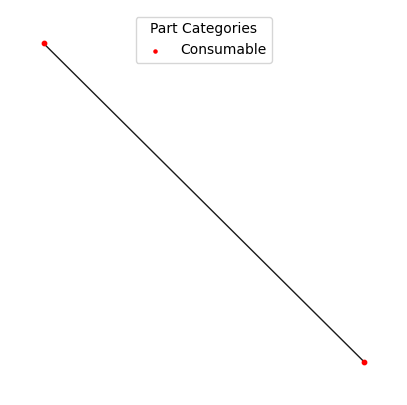

Component 134 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



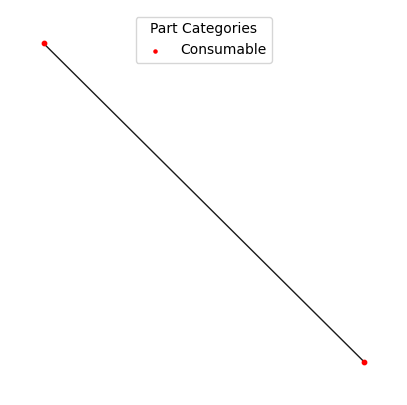

Component 135 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



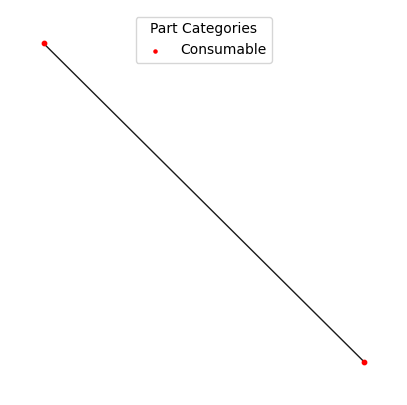

Component 136 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



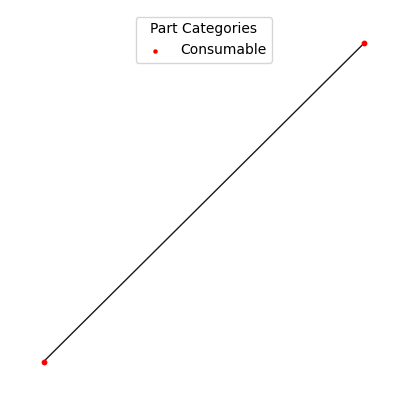

Component 137 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



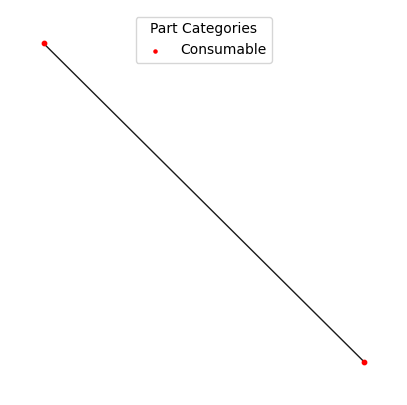

Component 138 : Graph with 2 nodes and 1 edges
Size: 2
Average Clustering Coefficient:  0.0
Density: 1.0



In [34]:
for i in range(len(S)):
  fig, ax = plt.subplots(figsize=(5,5))

  pos=nx.spring_layout(S[i])

  for category, color in color_map.items():
      category_nodes = [node for node in S[i].nodes() if S[i].nodes[node]["category"] == category]
      size_nodes=[S[i].nodes[node]["frequency"] for node in category_nodes]
      nx.draw_networkx_nodes(S[i], pos, nodelist=category_nodes, node_color=color, label=category,node_size=10)

  nx.draw_networkx_edges(S[i], pos, width=1.0, alpha=0.9)

  plt.axis("off")
  legend = ax.legend(title="Part Categories", loc='upper center', ncol=5)
  for handle in legend.legend_handles:
      handle.set_sizes([5])
  plt.show()

  print('Component',i,':', S[i])
  print('Size:',network_info[i]['size'])
  print('Average Clustering Coefficient: ',network_info[i]['cc'])
  print('Density:', network_info[i]['density'])
  print('')


# PART 4: Run community detection algorithm in the largest connected component

In [35]:
#insert colors for nodes

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

## 4.1 Largest connected component info

In [36]:
i=0
print(S[i])
print('-------------------------------------------------------')
print('Average clustering coefficient: ',network_info[i]['cc'])
print('Density:', network_info[i]['density'])

Graph with 1714 nodes and 16153 edges
-------------------------------------------------------
Average clustering coefficient:  0.6786576297540563
Density: 0.011003098687298244


## 4.2 Louvain algorithm on largest connected component  
- <b>Networkx documentation on Louvain algorithm</b>  
 https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html  

- <b>Modularity maximization approaches</b>   
https://arxiv.org/pdf/0803.0476.pdf  
https://web.eng.ucsd.edu/~massimo/ECE227/Handouts_files/TCSS-14-Modularity.pdf  





In [37]:
def comd_louvain(G):
  start = time.time()
  c=list(nx.algorithms.community.louvain_communities(G,'weight',resolution=1.5))
  end = time.time()
  print('Execution time:', end - start)
  mm_G=[]
  for i,j in enumerate(c):
      a=list(j)
      mm_G.append(a)
  per=nx.algorithms.community.quality.modularity(G,mm_G)
  per1=nx.algorithms.community.quality.partition_quality(G,mm_G)
  num_G=len(mm_G)
  return mm_G, per,num_G, per1[1], per1[0]

In [38]:
mm_G, modul, num_G, per, cov = comd_louvain(S[0])

Execution time: 0.392498254776001


# PART 5: Evaluate partition of the largest connected component
<b>Measures of network partition quality</b>
* <b>Modularity</b> quantifies the community strength by comparing
the fraction of edges within the community with the one when random connections between the nodes are made. A community is expected to
have more edges between its entities than the ones resulted by the same entities connected at random with the same number of links. Modularity score close to $1$ indicates strong community structure.
https://en.wikipedia.org/wiki/Modularity_(networks)
* <b>Coverage</b> of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.
* <b>Performance</b> of a partition is the ratio of intra-community edges plus inter-community non-edges (=correctly 'interpreted' pairs of nodes) to the total number of potential edges.

In [39]:
def generate_hist(metric_res, metric_name):
  plt.hist(metric_res, bins=100, edgecolor='black')
  plt.ylabel("Count")
  plt.xlabel(metric_name)
  plt.show()

  print("Component Average {}:".format(metric_name), np.mean(metric_res))
  print("Component {} Standard Deviation:".format(metric_name), np.std(metric_res))
  print("Minimun Component {}:".format(metric_name), min(metric_res))
  print("Maximum Component {}:".format(metric_name), max(metric_res))
  print('')

In [40]:
def evaluate_partition(coms,G):
  cc_com=[]
  density_com=[]
  in_strength_com=[]
  in_edges_num=[]

  out_strength_com=[]
  out_edges_num=[]

  for com in range(len(coms)):
    coms_g=G.subgraph(coms[com])
    in_edges_num.append(len(coms_g.edges()))
    cc_com.append(nx.average_clustering(coms_g))
    if len(coms_g.edges)>0:
      density_com.append(2*len(dict(coms_g.edges()))/(len(dict(coms_g.nodes()))*(len(dict(coms_g.nodes()))-1)))
    else:
      density_com.append(1)

    istr=0
    for e in coms_g.edges:
      istr+=G[e[0]][e[1]]['weight']
    in_strength_com.append(istr)

    out_neig=0
    ostr=0
    for n in coms[com]:
      for n2 in G.neighbors(n):
        if n2 not in coms_g.neighbors(n):
          out_neig+=1
          ostr+=G[n][n2]['weight']
    out_strength_com.append(ostr)
    out_edges_num.append(out_neig)

    in_strength_ratio=[in_strength_com[i]/(in_strength_com[i]+out_strength_com[i]) for i in range(len(in_strength_com))] # intra to (intra+inter)-community edge strength ratio
    in_edge_ratio=[in_edges_num[i]/(in_edges_num[i]+out_edges_num[i]) for i in range(len(in_edges_num))] # intra to (intra+inter)-community edge number ratio

  return(cc_com,density_com,in_strength_ratio,in_edge_ratio)

In [41]:
cc_com,density_com,in_strength_ratio,in_edge_ratio=evaluate_partition(mm_G,G)

In [42]:
print('LOUVAIN results')
print('--------------------------------------------------------------------')
print('Number of communities:', num_G)
print('')
print('Modularity score:', modul)
print('Performance score:', per)
print('Coverage score:', cov)
print('')
print('Average community size:', np.mean([len(i) for i in mm_G]))
print('Standard deviation of community size:', np.std([len(i) for i in mm_G]))
print('Max community size:', max([len(i) for i in mm_G]))
print('Min community size:', min([len(i) for i in mm_G]))
print('--------------------------------------------------------------------')
counter = collections.Counter(sorted([len(i) for i in mm_G]))
for c in counter:
  print('-', counter[c], 'community/ies of size ', c)

LOUVAIN results
--------------------------------------------------------------------
Number of communities: 39

Modularity score: 0.6961945931784526
Performance score: 0.9433653419761437
Coverage score: 0.7869745558100663

Average community size: 43.94871794871795
Standard deviation of community size: 53.40025387337555
Max community size: 227
Min community size: 2
--------------------------------------------------------------------
- 2 community/ies of size  2
- 2 community/ies of size  3
- 3 community/ies of size  4
- 1 community/ies of size  5
- 1 community/ies of size  6
- 2 community/ies of size  8
- 1 community/ies of size  9
- 1 community/ies of size  12
- 2 community/ies of size  13
- 1 community/ies of size  14
- 1 community/ies of size  16
- 1 community/ies of size  20
- 2 community/ies of size  21
- 1 community/ies of size  23
- 1 community/ies of size  26
- 1 community/ies of size  28
- 1 community/ies of size  33
- 1 community/ies of size  43
- 1 community/ies of size  51
-

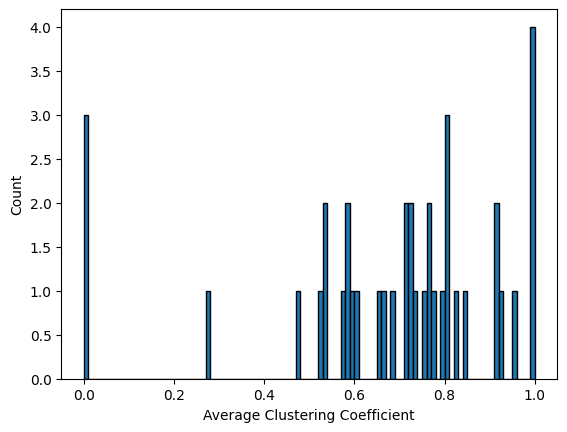

Component Average Average Clustering Coefficient: 0.6812037405735524
Component Average Clustering Coefficient Standard Deviation: 0.25400321533752024
Minimun Component Average Clustering Coefficient: 0.0
Maximum Component Average Clustering Coefficient: 1.0




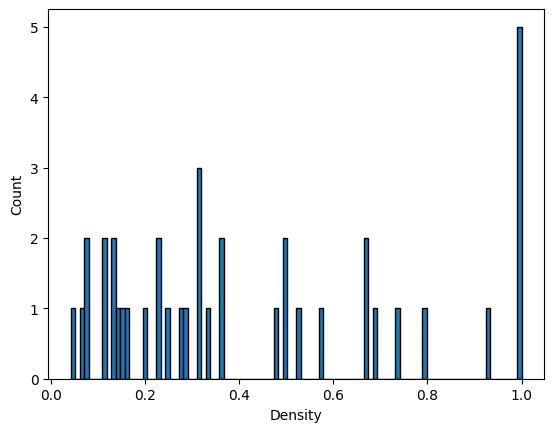

Component Average Density: 0.42900594630383493
Component Density Standard Deviation: 0.30948607838398956
Minimun Component Density: 0.042103621691162135
Maximum Component Density: 1.0




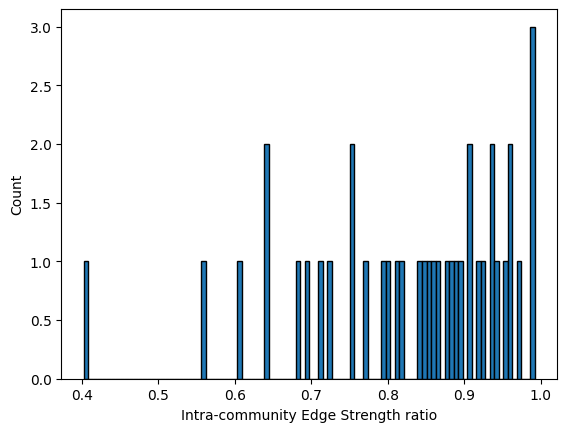

Component Average Intra-community Edge Strength ratio: 0.827791330470428
Component Intra-community Edge Strength ratio Standard Deviation: 0.13241398355543232
Minimun Component Intra-community Edge Strength ratio: 0.40276385313643137
Maximum Component Intra-community Edge Strength ratio: 0.9922244759972955




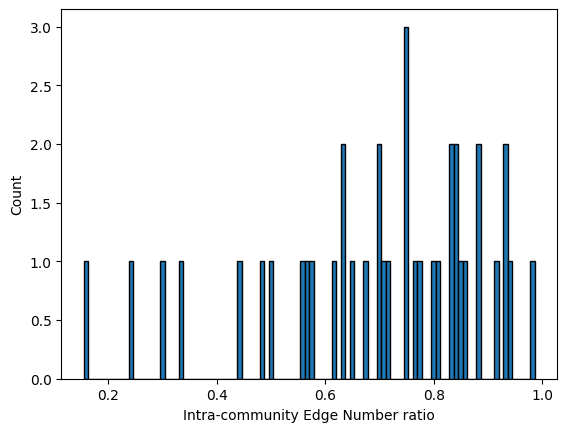

Component Average Intra-community Edge Number ratio: 0.694450560918972
Component Intra-community Edge Number ratio Standard Deviation: 0.199051956149769
Minimun Component Intra-community Edge Number ratio: 0.1546203110704483
Maximum Component Intra-community Edge Number ratio: 0.9859154929577465



In [43]:
generate_hist(cc_com, 'Average Clustering Coefficient')
print('')
generate_hist(density_com, 'Density')
print('')
generate_hist(in_strength_ratio, 'Intra-community Edge Strength ratio')
print('')
generate_hist(in_edge_ratio, 'Intra-community Edge Number ratio')

# PART 6: Graph of communities

## 6.1 Similarity between communities
Total strength of inter-community edges (= sum of inter-community edge weights)

In [44]:
def communities_sim(com,G): # com: node partition, G: initial graph

  com_sim=dict()
  com_edges=dict()
  for com1 in range(len(com)):
    for com2 in range(com1,len(com)):
      csim=0
      cedges=0
      for n1 in com[com1]:
        for n2 in com[com2]:
          if n1 in G.neighbors(n2):
            cedges+=1
            csim+=G[n1][n2]['weight']
      if com1!=com2:
        com_edges[(com1,com2)]=cedges
        com_sim[(com1,com2)]=csim
      else:
        com_edges[(com1,com2)]=cedges/2
        com_sim[(com1,com2)]=csim/2

  return com_edges,com_sim


In [45]:
com_edges,com_sim=communities_sim(mm_G,G)

### 6.1.1 Community similarity dataframe

In [46]:
com_sim_source=[i[0] for i in com_sim]
com_sim_dest=[i[1] for i in com_sim]
com_sim_sim=[com_sim[i] for i in com_sim]
data={'source':com_sim_source, 'destination':com_sim_dest, 'similarity':com_sim_sim}
df_sim=pd.DataFrame.from_dict(data)

In [47]:
df_sim

source  destination  similarity
0         0            0      9007.0
1         0            1         0.0
2         0            2         0.0
3         0            3         0.0
4         0            4         0.0
..      ...          ...         ...
775      36           37        14.0
776      36           38         0.0
777      37           37      7083.0
778      37           38         0.0
779      38           38       502.0

[780 rows x 3 columns]

#### Example: Similarity of community 1 to all other communities
If source and destination are equal to $1$, we get the total strength of the intra-community edges of community with index $1$.

In [52]:
df_sim[(df_sim['similarity']!=0) & ((df_sim['source']==0) | (df_sim['destination']==0))].sort_values(by=['similarity'],ascending=False)

source  destination  similarity
0        0            0      9007.0
17       0           17       486.0
6        0            6        45.0
36       0           36        34.0
22       0           22        14.0
29       0           29         6.0

## 6.2 Generate communities graph
Each node corresponds to a community.  
Two communities are connected, if there exists at least one edge between their parts.   
The weight of an edge that connects two communities is equal to the total strength of the edges connecting their parts (that is, the total strength of inter-community edges).

In [49]:
G_com=nx.Graph()
for i in com_sim:
  if com_sim[i]>0 and i[0]!=i[1]:
    G_com.add_edge(i[0],i[1],similarity=com_sim[i])
  elif i[0]==i[1]:
    G_com.add_node(i[0], strength=com_sim[i])

## 6.3 Visualize communities graph  
https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

(-1.2039135829771574,
 1.1459477065691335,
 -1.0933459997574375,
 1.1198270598941156)

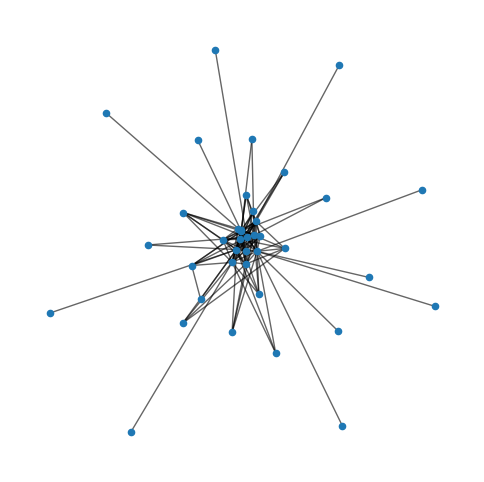

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
pos=nx.spring_layout(G_com,weight='similarity')

nx.draw_networkx_nodes(G_com, pos, nodelist=G_com.nodes(),node_size=20, alpha=1)
nx.draw_networkx_edges(G_com, pos, width=1, alpha=0.6)

plt.axis("off")

In [51]:
end=time.time()
print((end-start)/60, 'mins')

1.8117079536120098 mins
